<a href="https://colab.research.google.com/github/ArturoSirvent/TFG_notebooks/blob/main/Models_multiinput/primer_intento_clasificador_multiple_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#LIBRERIAS
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import keras.backend as K

# Creacion del modelo con el model (functional) API
[TUTORIAL AQUI](https://keras.io/guides/functional_api/)

## Funcion creacion de modelo


In [ ]:

def lambda_func(x):
    #si la imagen esta muy por debajo de la media la dejamos talcual
    print(K.mean(x))
    #media=K.mean(x,axis=-1)
    #if media<0.5:
    #    maximo=1
    #    pass
    #    #si esta normalita, lo dividimso todo por el maximo
    #else:
    #    maximo=K.max(x,)
    return x


def create_model(num_inputs,dims_inputs,num_class,pre_model=None,copy_pre=False):
#una funcion para crear el modelo con diferentes parámetros

    def block(input_lay):
        #x=tf.keras.layers.Lambda(lambda_func)(input_lay)
        x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(input_lay)
        x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Flatten()(x)
        #x=tf.keras.layers.Dropout(0.3)(x)
        #x=tf.keras.layers.Dense(25,activation="relu")(x)
        return x
    #creamos los diferentes inputs para nuestra funcion
    if len(dims_inputs)==1:
        dims_inputs=[dims_inputs[0] for _ in range(num_inputs)]
    inputs=[]
    for i in range(num_inputs):
        inputs.append(tf.keras.Input(shape=dims_inputs[i]))

    if not pre_model:
        #si no se nos pasa un modelo para el input lo que hacemos es crearlo
        #a cada input le vamos a aplicar la misma capa de feature extraction

        output_clasify=[]
        for j in inputs:
            output_clasify.append(block(j))

    elif pre_model:
        #en teoria es una lista de modelos, pero si la lista de solo uno, vamos a tomar ese para todas las ramas
        output_clasify=[]
        if len(pre_model)==1:
            if copy_pre:
                pesos=pre_model[0].get_weights()
                pre_model_new=[tf.keras.models.clone_model(pre_model[0]) for _ in range(num_inputs)]
                for i in range(num_inputs):
                    pre_model_new[i].set_weights(pesos)
                    pre_model_new[i]._name=f"Feature_extraction_{i+1}"
            else:
                pre_model_new=[pre_model[0] for _ in range(num_inputs)]
            for i,j in enumerate(inputs):
                output_clasify.append(pre_model_new[i](j))
        else:
            for i,j in enumerate(inputs):
                output_clasify.append(pre_model[i](j))
    if num_inputs==1:
        end_layer=tf.keras.layers.Dense(55,activation="relu")(output_clasify[0])
    else:
        end_layer=tf.keras.layers.Concatenate()(output_clasify)
        end_layer=tf.keras.layers.Dense(55,activation="relu")(end_layer)
    end_layer=tf.keras.layers.Dropout(0.3)(end_layer)
    end_layer=tf.keras.layers.Dense(28,activation="relu")(end_layer)
    end_layer=tf.keras.layers.Dropout(0.3)(end_layer)
    end_layer=tf.keras.layers.Dense(14,activation="relu")(end_layer)
    end_layer=tf.keras.layers.Dense(num_class,activation="softmax")(end_layer)
    model=tf.keras.Model(inputs=inputs,outputs=end_layer,name="prueba_red")
    return model

In [ ]:
model_multi=create_model(1,[(55,93,1)],7)
model_multi.summary()
model_multi.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

hist=model_multi.fit(x_train_list[0],y_train_list,epochs=50,batch_size=128,validation_data=(x_test_list[0],y_test_list),callbacks=[stop])


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Model: "prueba_red"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 55, 93, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 93, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 93, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 46, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 23, 32)        9

NameError: ignored

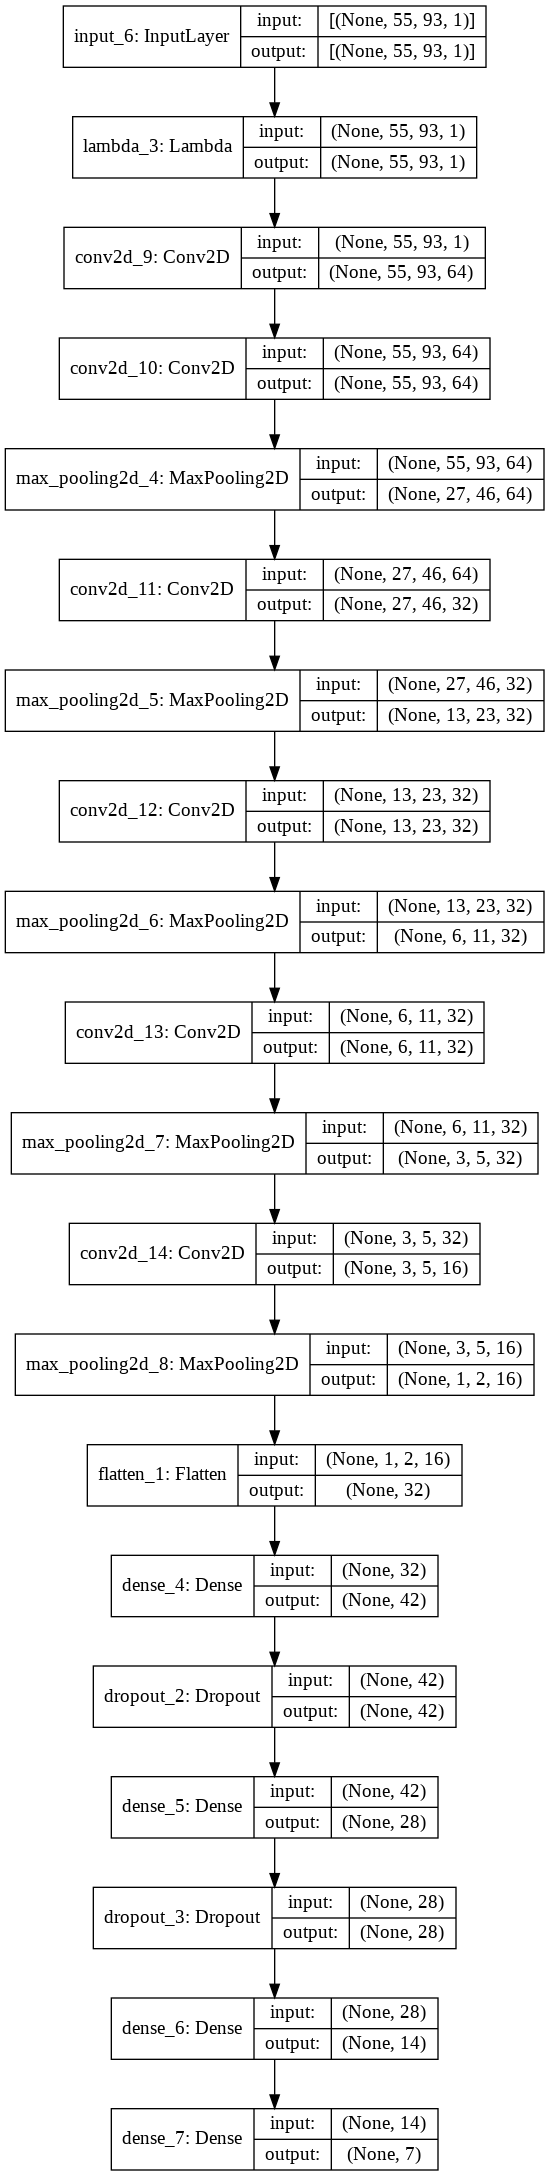

In [ ]:
v=tf.keras.utils.plot_model(model_multi, "prueba_1.png", show_shapes=True)
v

In [ ]:
ruta="/content/drive/MyDrive/prediccion_datos_muchos_telescopios"
model_nuevo=tf.keras.models.load_model(f"{ruta}/model_feature_extraction_1.h5")
model_nuevo_parte=tf.keras.Sequential(model_nuevo.layers[:7])
model_nuevo_parte.build(input_shape=model_nuevo_parte.layers[0].input.shape)
b=create_model(4,[(55,93,1)],7,pre_model=[model_nuevo_parte],copy_pre=True)
b.summary()

Model: "prueba_red"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 55, 93, 1)]  0                                            
_________________________________________________________________________________________

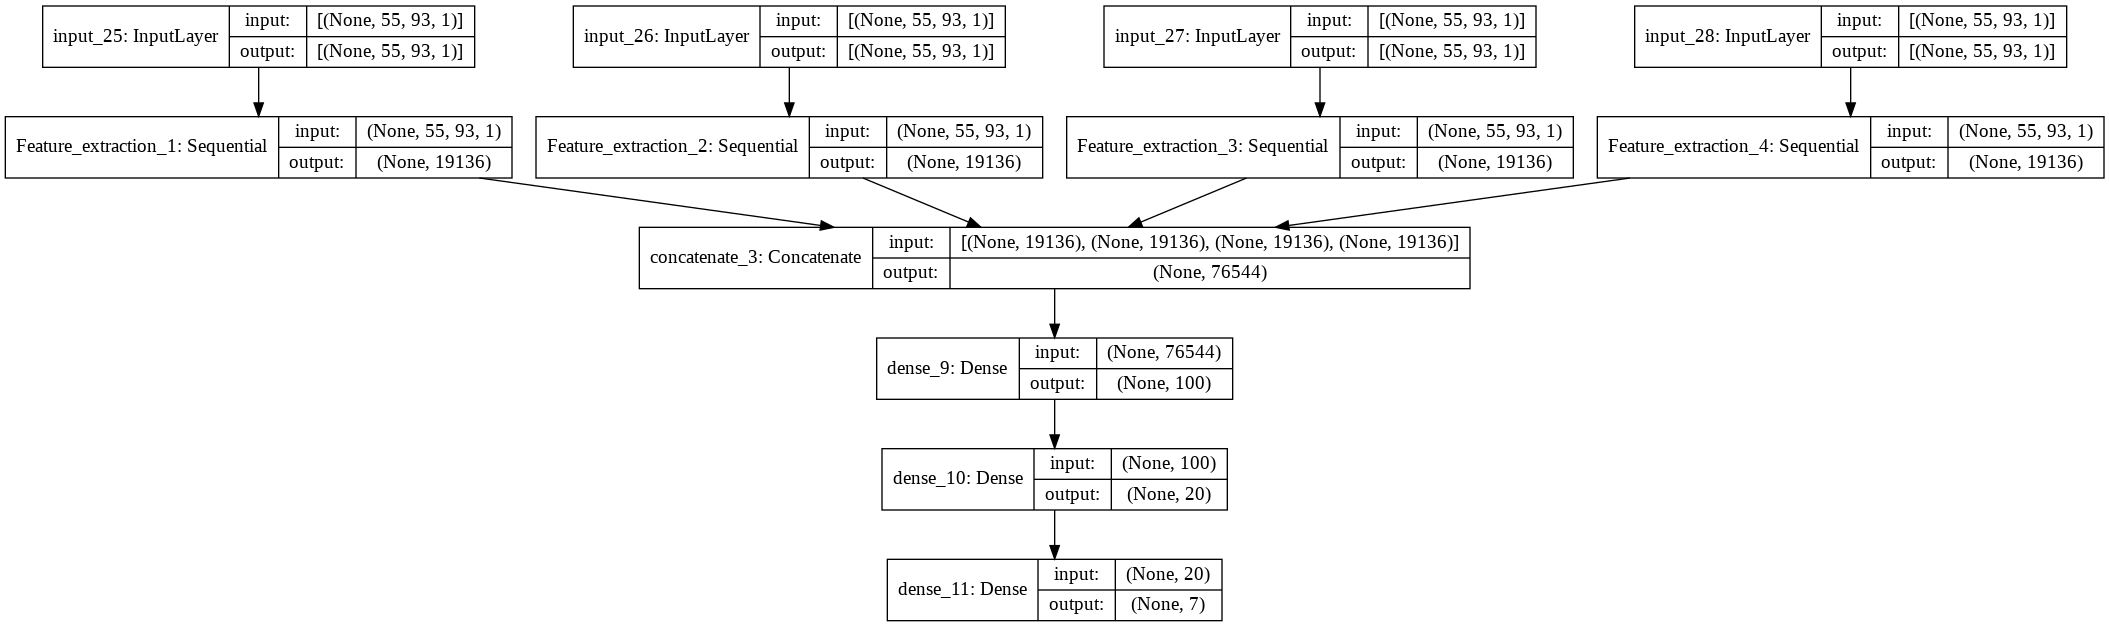

In [ ]:
tf.keras.utils.plot_model(b, "prueba_1.png", show_shapes=True)


Model: "prueba_red"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 55, 93, 1)]  0                                            
_________________________________________________________________________________________

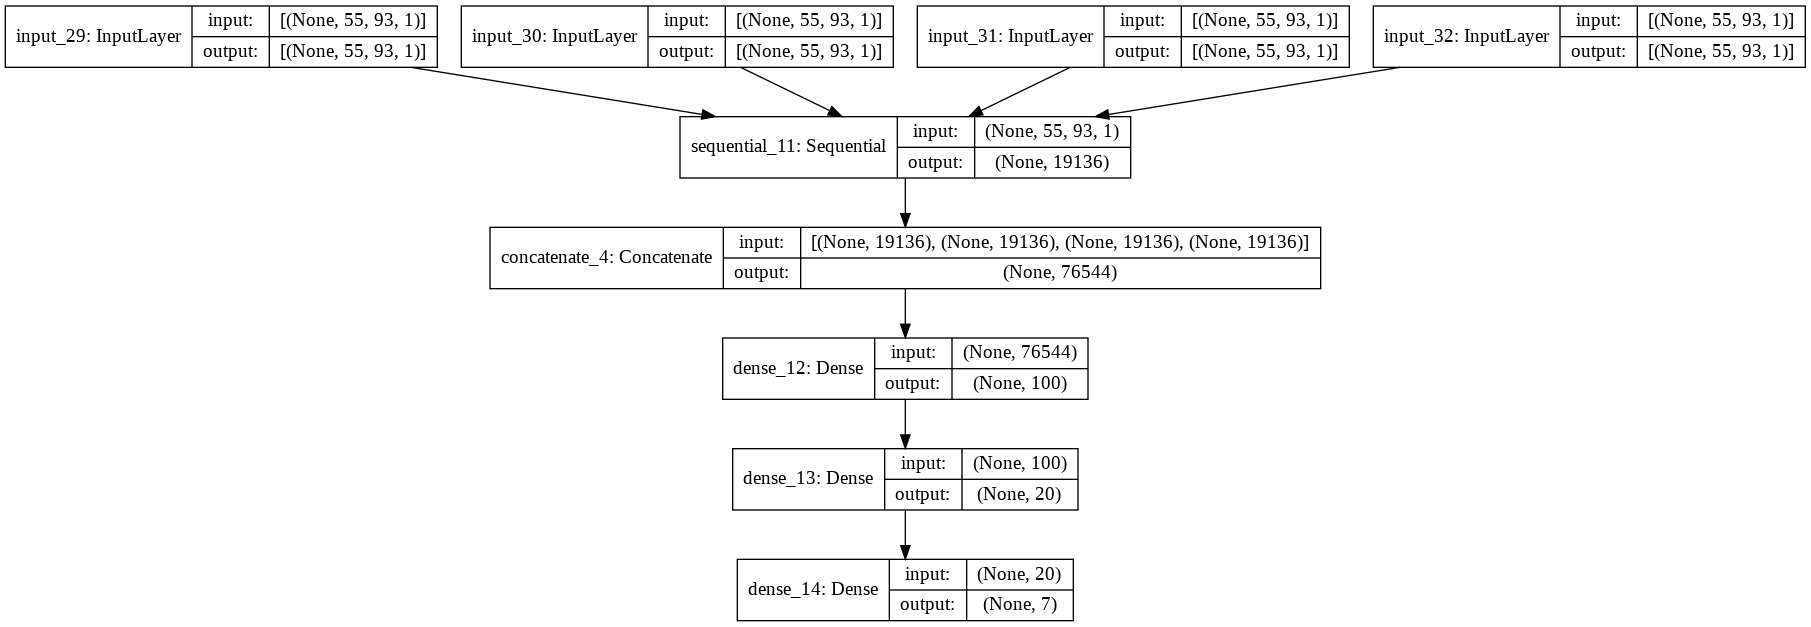

In [ ]:
ruta="/content/drive/MyDrive/prediccion_datos_muchos_telescopios"
model_nuevo=tf.keras.models.load_model(f"{ruta}/model_feature_extraction_1.h5")
model_nuevo_parte=tf.keras.Sequential(model_nuevo.layers[:7])
model_nuevo_parte.build(input_shape=model_nuevo_parte.layers[0].input.shape)
b=create_model(4,[(55,93,1)],7,pre_model=[model_nuevo_parte],copy_pre=False)
b.summary()
tf.keras.utils.plot_model(b, "prueba_1.png", show_shapes=True)

Estoy haciendo pasar los 4 inputs por el mismo modelo de extraccion de features, luego nos devuelve valores diferentes para cada uno de los inputs
y los concatenamos. Creo que se vamos a reciclar la arquitectura del feature extractor, no hara falta meter una instancia del modelo cada vez.

Es probable que si lo queremos entrenar, esto nos pueda estar dando problemas, porque se verá actualizado debido a los 4 inputs, y si uno quiere una coas y otro otra quizá entran en conflicto....

# Cargamos datos y probamos modelos:

## (Reentreno) Primero para el modelo individual del que hemos sacado los filtros

Lo tenemos que reentrenar porque lo entrene con sparse_categorical_crossentropy y eso esta mal si hacemos el output to_categorical



In [ ]:
npy="/content/drive/MyDrive/analisis_datos_tfg_inicial_hasta_4_02_21/npy_archivos_tel_1"

#cargamos los archivos y los metemos en una lista unos detras de otros
elements_npy=['gamma_8', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
#elements_npy=["electron","nitrogen","silicon","iron","proton","helium","gamma_0","gamma_1"]
elements=["electron","nitrogen","silicon","iron","proton","helium","gamma"]

In [ ]:
data=[]
for i in elements_npy:
  data.append(np.load(f"{npy}/{i}.npy"))



In [ ]:
data_new_2=np.concatenate([*data])


In [ ]:
print(data_new_2.shape)

(102345, 55, 93)


In [ ]:
#forma 1
labels=[]
for i in range(len(data)):
    labels.append((i)*np.ones(data[i].shape[0]))

labels_new=np.concatenate([*labels])
print(labels_new.shape)

(102345,)


In [ ]:
labels

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([2., 2., 2., ..., 2., 2., 2.]),
 array([3., 3., 3., ..., 3., 3., 3.]),
 array([4., 4., 4., ..., 4., 4., 4.]),
 array([5., 5., 5., ..., 5., 5., 5.]),
 array([6., 6., 6., ..., 6., 6., 6.])]

In [ ]:
del labels, data

In [ ]:
#ahora creamos con los datos el data set
X_train, X_test, y_train, y_test = train_test_split(data_new_2, labels_new, test_size=0.33, random_state=42)

In [ ]:
del data_new_2, labels_new

In [ ]:

#vamos a darle una dimension mas a los datos, la batch
X_train=X_train[...,np.newaxis]
X_test=X_test[...,np.newaxis]
y_train=tf.keras.utils.to_categorical(y_train)
y_test=tf.keras.utils.to_categorical(y_test)

In [ ]:
X_test.shape

(33774, 55, 93, 1)

In [ ]:
model_entrenado=tf.keras.models.load_model("/content/drive/MyDrive/pruebas_clasificacion_tfg_26_02_2021/Clasificacion_multiclass_1er_intento_tel_1/primer_modelo_4.h5")

In [ ]:
model_entrenado.summary()
model_entrenado.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 55, 93, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 55, 93, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 46, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 27, 46, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 46, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 13, 23, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 19136)            

In [ ]:
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=7)
hist=model_entrenado.fit(X_train,y_train,batch_size=128,epochs=100,validation_data=(X_test,y_test),callbacks=[stop])
ruta="/content/drive/MyDrive/prediccion_datos_muchos_telescopios"
#model_entrenado.save(f"{ruta}/model_feature_extraction_1.h5")

Epoch 1/100
536/536 [==============================] - 60s 51ms/step - loss: 9.5068 - accuracy: 0.2974 - val_loss: 0.9741 - val_accuracy: 0.5325
Epoch 2/100
536/536 [==============================] - 26s 48ms/step - loss: 1.2462 - accuracy: 0.5270 - val_loss: 0.7534 - val_accuracy: 0.7163
Epoch 3/100
536/536 [==============================] - 26s 49ms/step - loss: 1.0181 - accuracy: 0.6078 - val_loss: 0.6147 - val_accuracy: 0.7928
Epoch 4/100
536/536 [==============================] - 26s 49ms/step - loss: 0.8945 - accuracy: 0.6599 - val_loss: 0.5946 - val_accuracy: 0.8055
Epoch 5/100
536/536 [==============================] - 26s 48ms/step - loss: 0.8225 - accuracy: 0.6994 - val_loss: 0.5558 - val_accuracy: 0.8198
Epoch 6/100
536/536 [==============================] - 26s 49ms/step - loss: 0.7870 - accuracy: 0.7155 - val_loss: 0.5114 - val_accuracy: 0.8277
Epoch 7/100
536/536 [==============================] - 26s 49ms/step - loss: 0.7456 - accuracy: 0.7329 - val_loss: 0.5449 - val_ac

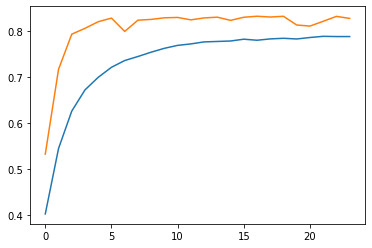

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])

## vamos a cargar datos para varios Telescopios y usar un modelo sencillo

Model: "prueba_red"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 55, 93, 1)]  0                                            
_________________________________________________________________________________________

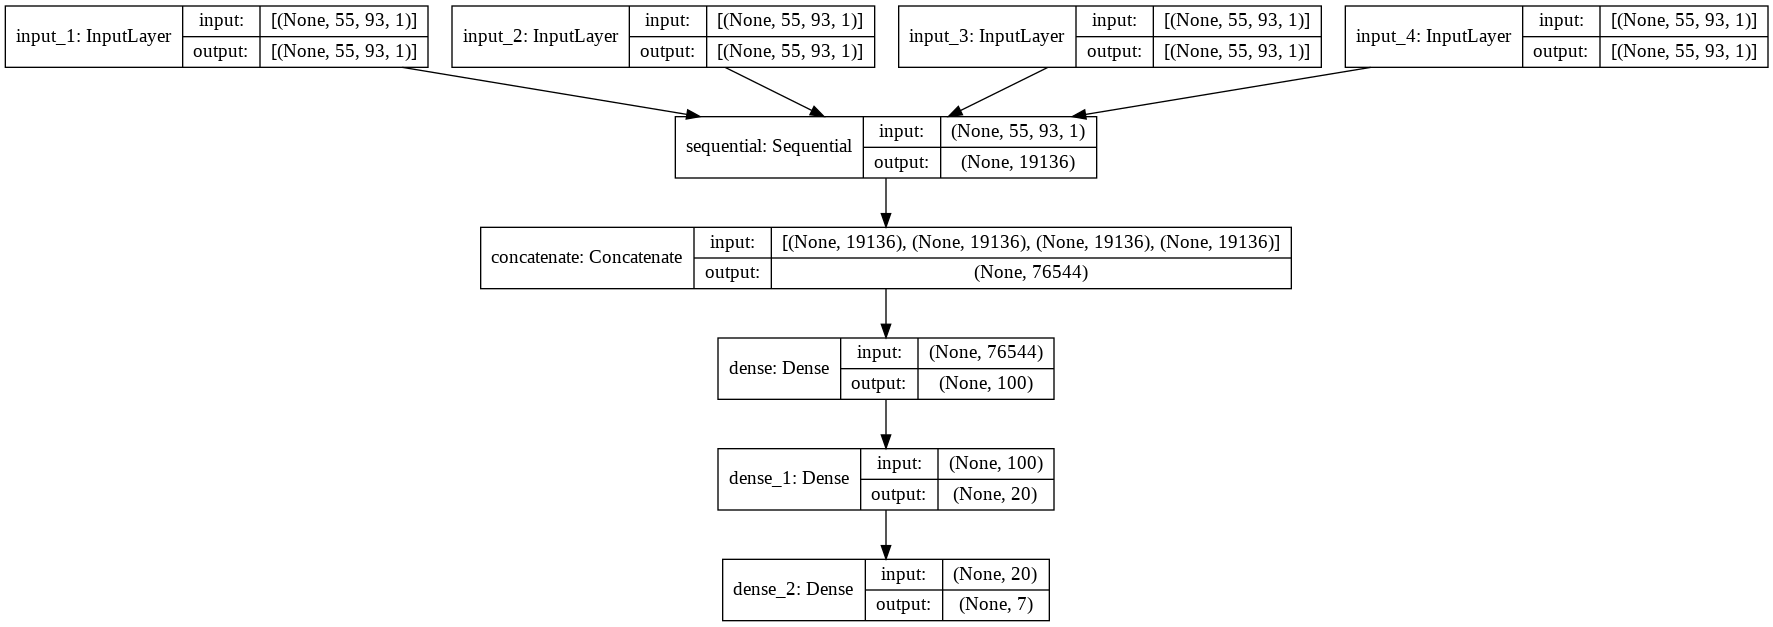

In [ ]:
#creamos el modelo, 
ruta="/content/drive/MyDrive/prediccion_datos_muchos_telescopios"
model_nuevo=tf.keras.models.load_model(f"{ruta}/model_feature_extraction_1.h5")
model_nuevo_parte=tf.keras.Sequential(model_nuevo.layers[:7])
model_nuevo_parte.build(input_shape=model_nuevo_parte.layers[0].input.shape)
inputs=4
input_shape=[(55,93,1)]
multi_model=create_model(inputs,input_shape,7,pre_model=[model_nuevo_parte],copy_pre=False)
multi_model.summary()
tf.keras.utils.plot_model(multi_model, "prueba_1.png", show_shapes=True)

In [ ]:
#congelamos la capa que nos hace feature extraction
multi_model.layers[inputs].trainable=False
multi_model.summary()

Model: "prueba_red"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 55, 93, 1)]  0                                            
_________________________________________________________________________________________

In [ ]:
multi_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
#nos falta cargar lo datos.
#esto puede ser un poco triky porque necesitamos cargar para los mismos 4 telescopios, 
#de diferentes carpetas y varias RUNS (si no todas)

def load_data(npy_dir,tels=None,runs=None,indices_runs=None,only_names=True,ending=".npy"):
    #aplicamos regular expresions para extraer los documentos deseados
    #usamos glob
    #si no pasamos ni los tesls ni las runs, deolvemos todos los arichivos
    #es poco optimo este uso de glob, pero es mas flexivo porque le puedo pasar los tels concretos y los runs concretos
    lista=[]
    if (type(tels)==list) or (type(tels)==np.ndarray):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            for j in runs:
                regex=f"{npy_dir}/*_tel_{i}_run_{str(j).zfill(2)}_?{ending}"
                aux=glob.glob(regex)
                if aux:
                    lista.extend(aux)
                else:
                    #si no lo encuentra entonces nos saldra mal la cosa
                    print("ERROR")
                    print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")

    elif (type(runs)==list) or (type(runs)==np.ndarray):
        #si no es una lista pero las runs si entonces seguimos con esto
        for j in runs:
            regex=f"{npy_dir}/*_tel_{tels}_run_{str(j).zfill(2)}_?{ending}"
            aux=glob.glob(regex)
            if aux:
                lista.extend(aux)
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")
    elif (tels==None) and (runs==None):
        #y sino por ultimo esto
        regex=f"{npy_dir}/*_tel_*_run_*_?{ending}"
        aux=glob.glob(regex)
        if aux:
            lista.extend(aux)
    else:
        print("ERROR")
    if only_names:
        return lista
    else:
        lista_npy=np.load(lista[0])[indices_runs[0]]
        for m,k in enumerate(lista[1:]):
            lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
        return lista_npy


"""
        lista_npy=[]
        for k in lista:
            lista_npy.append(np.load(k))
        return lista_npy



        lista_npy=np.load(lista[0])
        for k in lista[1:]:
            lista_npy=np.concatenate((lista_npy,np.load(k)),axis=0)
        return lista_npy
"""

'\n        lista_npy=[]\n        for k in lista:\n            lista_npy.append(np.load(k))\n        return lista_npy\n\n\n\n        lista_npy=np.load(lista[0])\n        for k in lista[1:]:\n            lista_npy=np.concatenate((lista_npy,np.load(k)),axis=0)\n        return lista_npy\n'

In [ ]:
def get_common_events(npy_dir_base,tels=None,run=None):
    #esta funcion nos sirve para obtener los indices de eventos comunes tal que 
    #esto es necesario para que las imagenes sean del mismo evento

    #TENEMOS QUE MIRAR PARA UNA RUN, TODOS LOS TELESCOPIOS QUE NOS INTERESEN,
    #SIN IMPORTAR EL ELEMENTO, SOLO LOS TELESCOPIOS DE LA RUN Y EL EMENTO QUE TOQUE
    lista=[]
    if (type(tels)==list) or (type(tels)==np.ndarray):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            regex=f"{npy_dir_base}/id_eventos_*_tel_{i}_run_{str(run).zfill(2)}.npy"
            aux=glob.glob(regex)
            if aux:
                lista.append(np.load(aux[0]))
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir_base)} no se encuentra el {os.path.basename(regex)}.")
    else:
        print("ERROR")
        return None
    sets=[set(i) for i in lista]
    #devolvemos una lista de los INDICES de los eventos que SON COMUNES y podemos coger
    indices_master=[]
    evantos_comunes=sorted(list(sets[0].intersection(*sets[1:])))
    del sets
    for i,j in enumerate(tels):
        indices=[]
        for k in evantos_comunes:
            indices.append(np.where(lista[i]==k)[0][0])
        indices_master.append(np.array(indices))
    return np.array(indices_master)




In [ ]:
#ejemplo de uso
npy_dir="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data/npy_nitrogen"
a=get_common_events(npy_dir,tels=[4,5,6,11],run=4)
a

In [ ]:
#EJEMPLO DE USO 
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

#DEBE SEGUIR ESTA ESTRUCTURA EL OUTPUT!!!!!!!!
#SE ENTRENA EL MODELO PARA UNA FORMA DE OUTPUT CONCRETA
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']

telescopios=[4,5,6,11]
list_runs=np.arange(1,3)
#para cada elemento y para cada RUN tenemos que indicar los eventos validos
eventos_elementos=[]
for i,j in enumerate(elementos):
    npy_dir_aux=f"{npy_base}/npy_{j}"
    eventos_runs=[]
    for l,k in enumerate(list_runs):
        aux_events=get_common_events(npy_dir_aux,tels=telescopios,run=k)
        eventos_runs.append(np.array(aux_events))
    eventos_elementos.append(eventos_runs)

a=[i[0,:] for i in eventos_elementos[1] ]
a[0][[4,5,6]]

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

#DEBE SEGUIR ESTA ESTRUCTURA EL OUTPUT!!!!!!!!
#SE ENTRENA EL MODELO PARA UNA FORMA DE OUTPUT CONCRETA
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']

telescopios=[4]#,5,6,11]
list_runs=np.arange(1,14)
#para cada elemento y para cada RUN tenemos que indicar los eventos validos
eventos_elementos=[]
for i,j in enumerate(elementos):
    dir_aux=f"{npy_base}/npy_{j}"
    eventos_runs=[]
    for l,k in enumerate(list_runs):
        aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
        eventos_runs.append(aux_events)
    eventos_elementos.append(eventos_runs)

#ahora tenemos los eventos que si nos valen porque estan en todos los telescopios a considerar 
x_train_list=[]
x_test_list=[]
for l,k in enumerate(telescopios):
    for i,j in enumerate(elementos):
        dir_aux=f"{npy_base}/npy_{j}"
        #HAY UN PROBLEMA, TENEMOS QUE SELECCIONAR LOS ELEMENTOS CON LA MISMA ID DE EVENTO
        #TENEMOS QUE TENER UNA LISTA DE LOS INDICES QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
        #lo que hacemos es pasarle una lista de los indices PARA:
        #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
        data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
        label_size=data_aux.shape[0]

        if i==0:
            labels=np.zeros(label_size)
            data=data_aux.copy()
            del data_aux
        else:
            labels=np.concatenate((labels,np.ones(label_size)*i),axis=0)
            data=np.concatenate((data,data_aux),axis=0)
            del data_aux
    print(data.shape)
    #ahora le aumentamos el canal y las labels las volvemos categorical
    data=data[...,np.newaxis]
    labels=tf.keras.utils.to_categorical(labels)
    x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=0.2,random_state=42)
    del data,labels
    x_train_list.append(x_train)
    print(f"Forma de y_train: {y_train.shape}")
    x_test_list.append(x_test)
    print(f"Forma de y_test: {y_test.shape}")
    if l==0:
        y_train_list=y_train
        y_test_list=y_test
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)



(61241, 55, 93)
Forma de y_train: (48992, 7)
Forma de y_test: (12249, 7)
(48992, 55, 93, 1) (12249, 55, 93, 1) (48992, 7) (12249, 7)


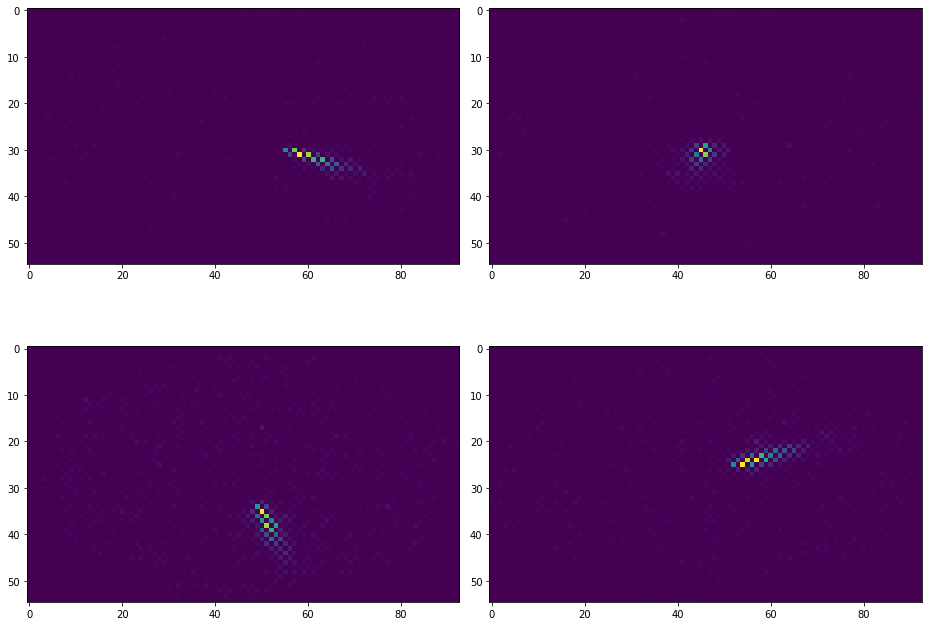

In [ ]:
plt.figure(figsize=(13,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(x_train_list[i][171,:,:,0])
plt.tight_layout()

## Entrenamos el model MULTI INPUT


In [ ]:
#MASTER CODE BIEN
historia_master=[]
model_multi=create_model(6,[(55,93,1)],7)
model_multi.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6)
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
telescopios=[4,5,60,58,6,11]
for n in range(1,16,4):

    list_runs=np.arange(n,n+2)
    print(f"Para las runs: {list_runs}")
    eventos_elementos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{npy_base}/npy_{j}"
        eventos_runs=[]
        for l,k in enumerate(list_runs):
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            eventos_runs.append(aux_events)
        eventos_elementos.append(eventos_runs)
    x_train_list=[]
    x_test_list=[]
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{npy_base}/npy_{j}"
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
            #maximo_aux=np.amax(data_aux)
            label_size=data_aux.shape[0]
            if i==0:
                labels=np.zeros(label_size)
                data=data_aux.copy()#/maximo_aux
                del data_aux
            else:
                labels=np.concatenate((labels,np.ones(label_size)*i),axis=0)
                data=np.concatenate((data,data_aux),axis=0) #/maximo_aux
                del data_aux
        print(np.amax(data))
        data=data[...,np.newaxis]#/np.amax(data)
        labels=tf.keras.utils.to_categorical(labels,num_classes=7)
        x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=0.25,random_state=42)

        del data,labels
        x_train_list.append(x_train)
        x_test_list.append(x_test)
        if l==0:
            y_train_list=y_train
            y_test_list=y_test
    hist=model_multi.fit(x_train_list,y_train_list,epochs=50,batch_size=128,validation_data=(x_test_list,y_test_list),callbacks=[stop])
    historia_master.append(hist)

Para las runs: [1 2]
1661.2
1661.4
1861.1
1700.7
1642.9
1648.8
Epoch 1/50
32/32 [==============================] - 14s 388ms/step - loss: 1.8006 - accuracy: 0.2678 - val_loss: 0.7416 - val_accuracy: 0.7440
Epoch 2/50
32/32 [==============================] - 12s 374ms/step - loss: 0.7576 - accuracy: 0.7343 - val_loss: 0.5716 - val_accuracy: 0.7778
Epoch 3/50
32/32 [==============================] - 12s 378ms/step - loss: 0.6025 - accuracy: 0.7749 - val_loss: 0.5371 - val_accuracy: 0.8153
Epoch 4/50
32/32 [==============================] - 12s 380ms/step - loss: 0.5507 - accuracy: 0.8034 - val_loss: 0.5099 - val_accuracy: 0.8311
Epoch 5/50
32/32 [==============================] - 12s 380ms/step - loss: 0.5096 - accuracy: 0.8202 - val_loss: 0.5050 - val_accuracy: 0.8311
Epoch 6/50
32/32 [==============================] - 12s 380ms/step - loss: 0.4854 - accuracy: 0.8252 - val_loss: 0.4539 - val_accuracy: 0.8476
Epoch 7/50
32/32 [==============================] - 12s 381ms/step - loss: 0.48

In [ ]:
model_multi.save("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/primer_exito_acc_0998.h5")

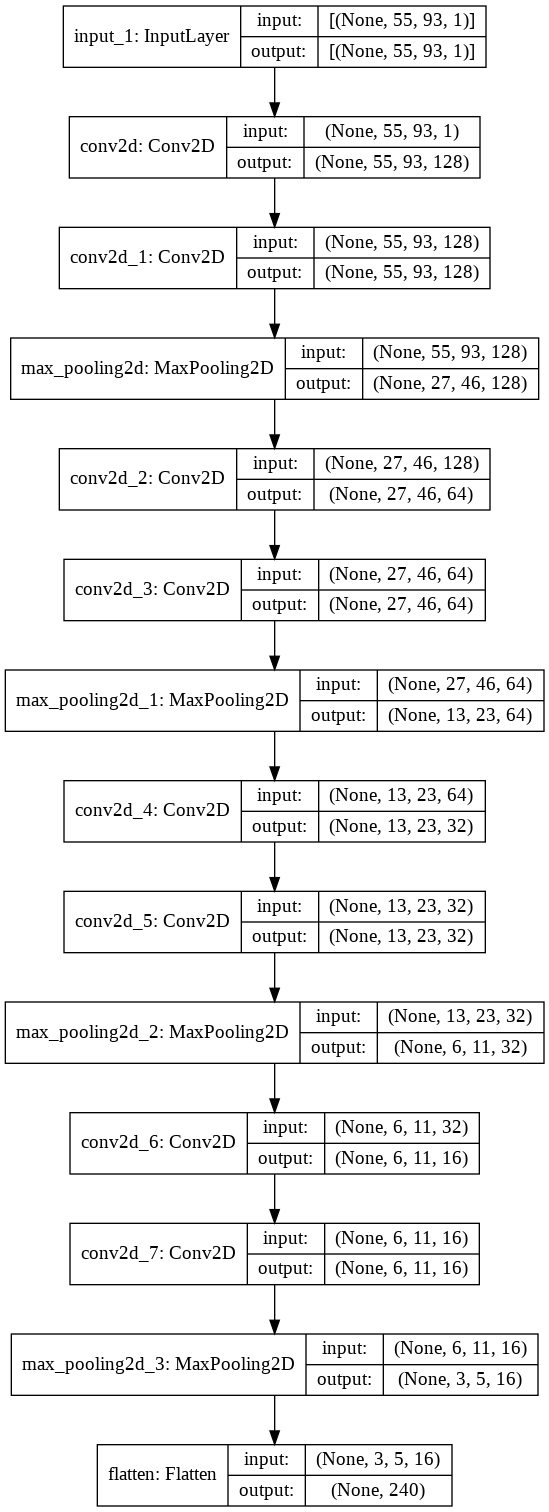

In [ ]:
#creamos una capa que sera solo para compartir los filtros
def blocke(input_lay):
    #x=tf.keras.layers.BatchNormalization()(input_lay)
    x=tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu")(input_lay)
    x=tf.keras.layers.Conv2D(128,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.MaxPool2D((2,2))(x)
    x=tf.keras.layers.Conv2D(64,(5,5),padding="same",activation="relu")(x)
    x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.MaxPool2D((2,2))(x)
    x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.MaxPool2D((2,2))(x)
    x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
    x=tf.keras.layers.MaxPool2D((2,2))(x)
    x=tf.keras.layers.Flatten()(x)
    return x
input_comp=tf.keras.Input(shape=(55,93,1))
output_comp=blocke(input_comp)
model_comp=tf.keras.Model(inputs=input_comp, outputs=output_comp)
tf.keras.utils.plot_model(model_comp, "prueba_1.png", show_shapes=True)

Model: "prueba_red"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 55, 93, 1)]  0                                            
_________________________________________________________________________________________

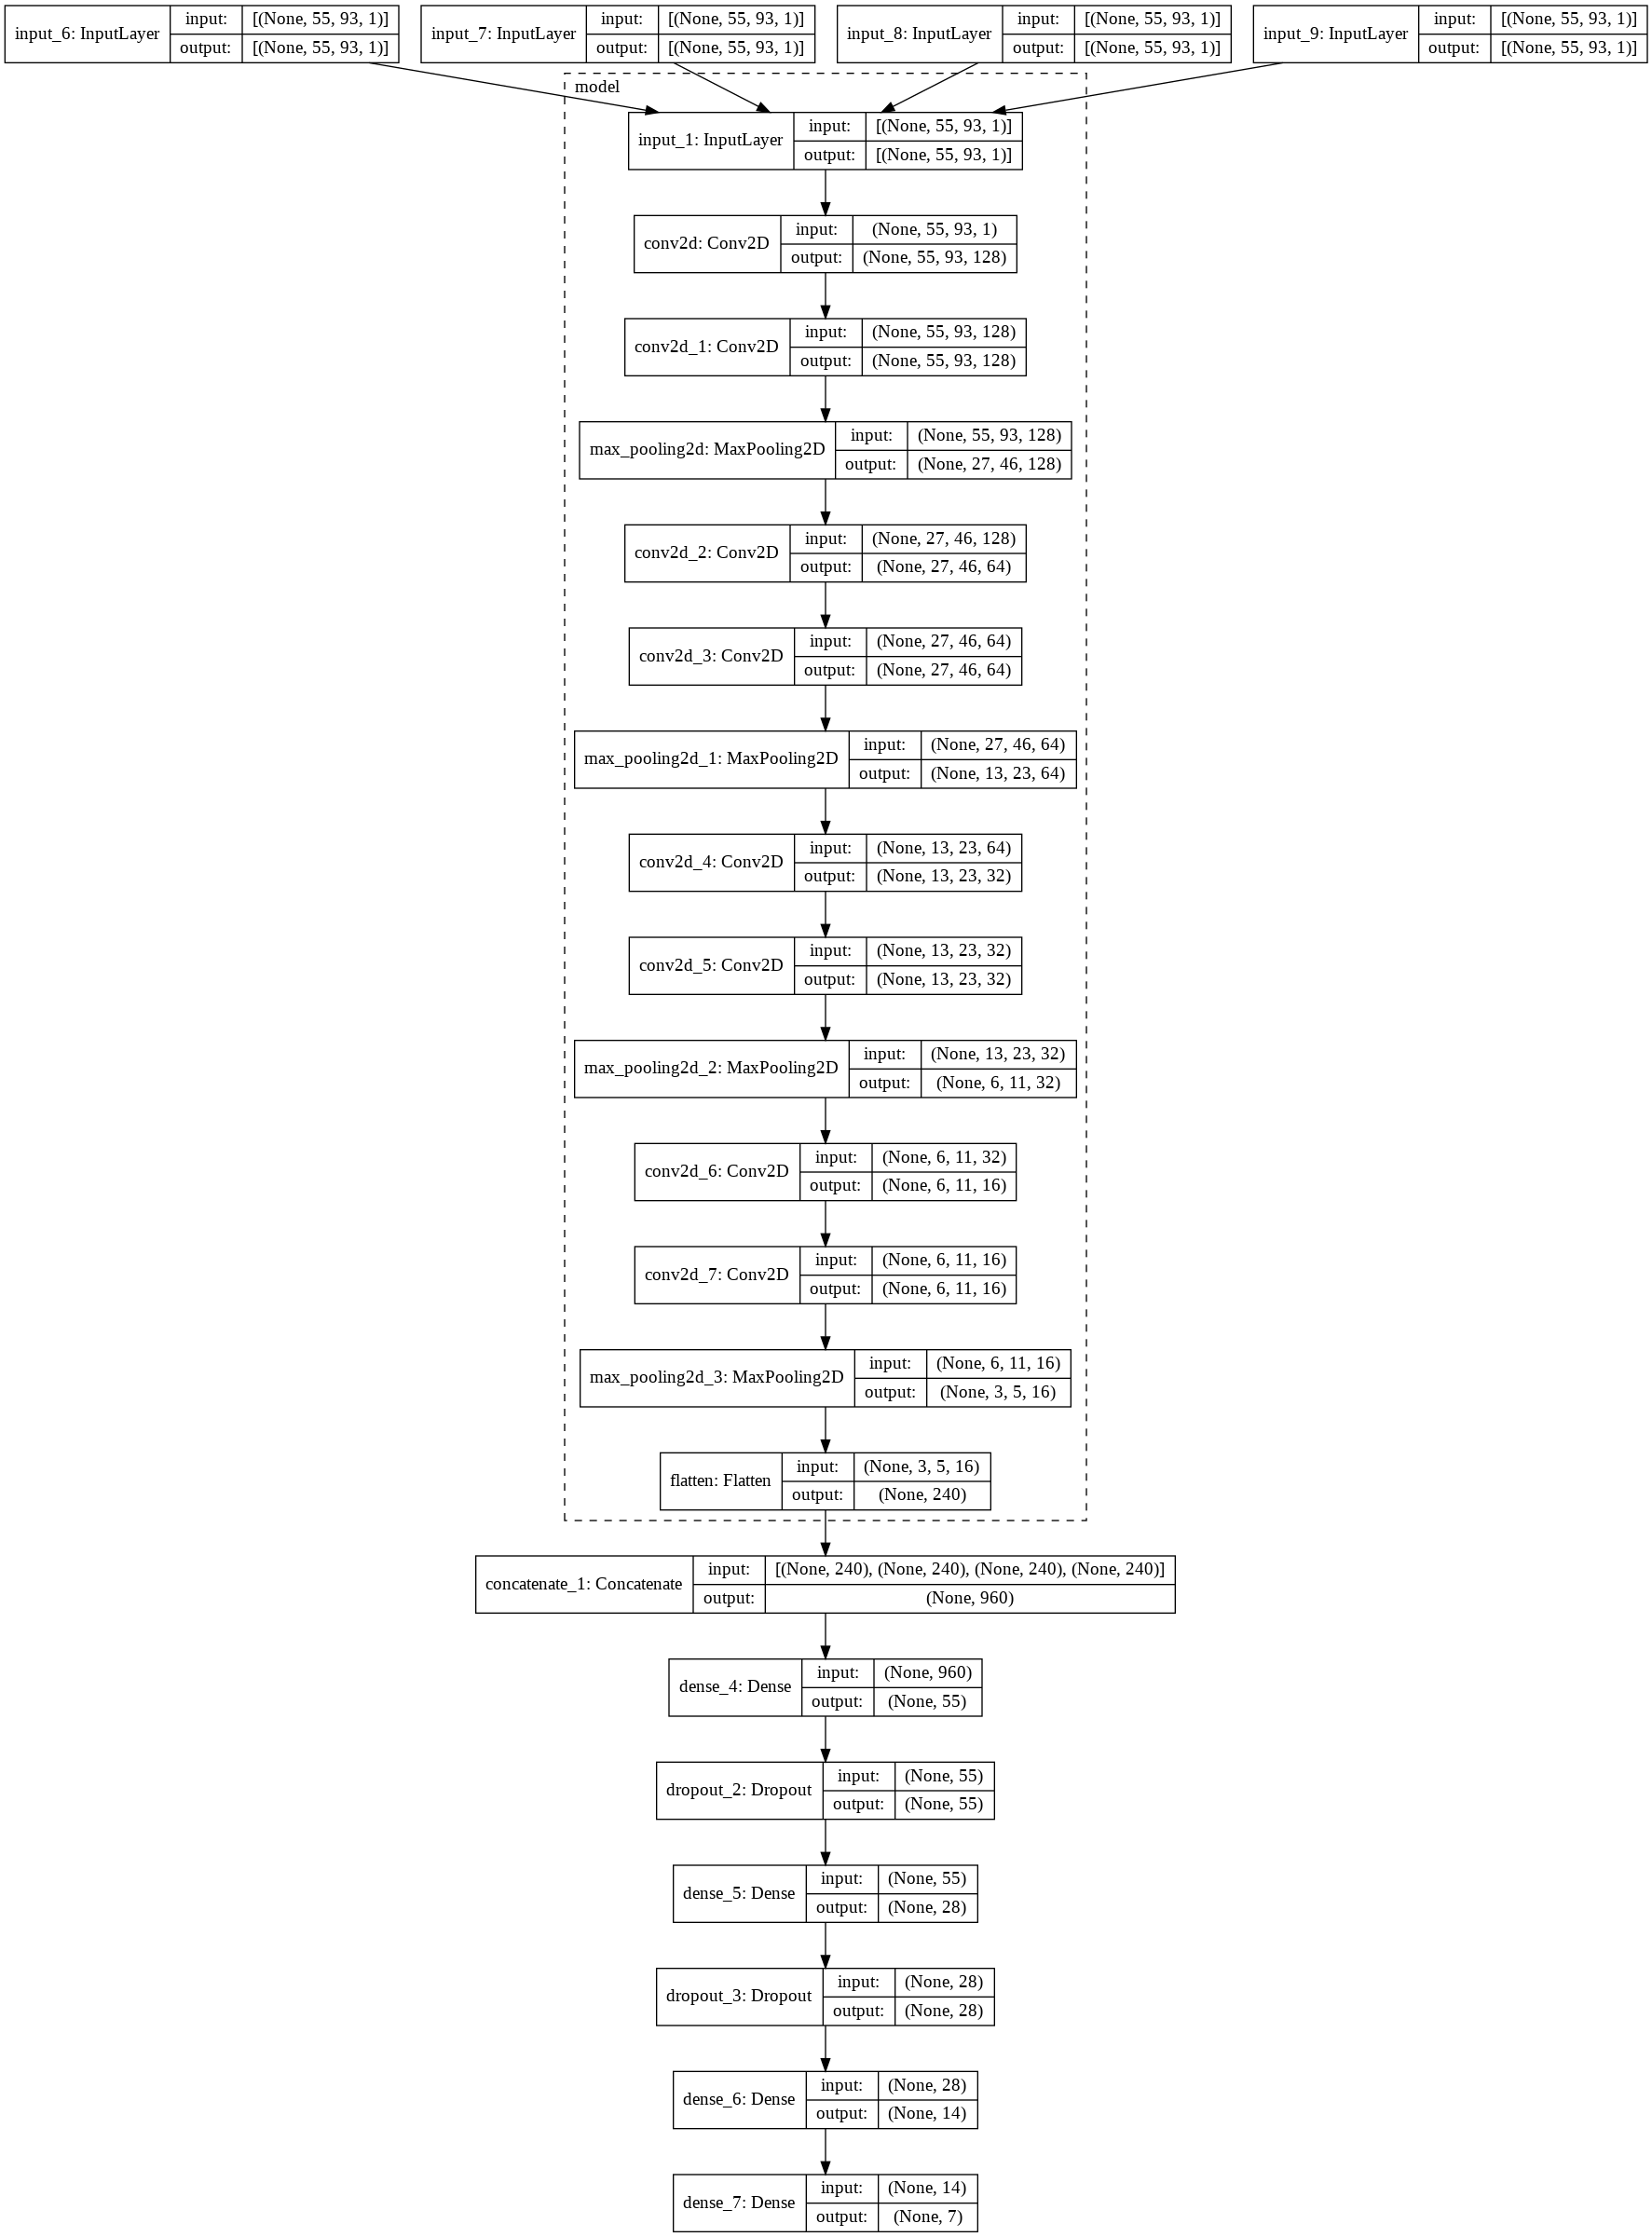

In [ ]:
#ahora que tenemos ese modelo, lo vamos a meter en nuestro creador de modelos
model_multi2=create_model(4,[(55,93,1)],7,pre_model=[model_comp])
model_multi2.summary()
tf.keras.utils.plot_model(model_multi2, "prueba_1.png", show_shapes=True,expand_nested=True)

In [ ]:
model_multi2.summary()

Model: "prueba_red"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 55, 93, 1)]  0                                            
_________________________________________________________________________________________

In [ ]:
#MASTER CODE BIEN 2
historia_master2=[]

#model_multi2=create_model(4,[(55,93,1)],7)
model_multi2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"#/npy_elementos_tel_1"
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6)
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
telescopios=[4,5,6,11]
for n in range(1,18,4):
    #no llegamos a mayores runs por el IRON, hay que arreglar eso
    list_runs=np.arange(n,n+3)
    print(f"Para las runs: {list_runs}")
    eventos_elementos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{npy_base}/npy_{j}" #tel_1_{j}"
        eventos_runs=[]
        for l,k in enumerate(list_runs):
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            eventos_runs.append(aux_events)
        eventos_elementos.append(eventos_runs)
    x_train_list=[]
    x_test_list=[]
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{npy_base}/npy_{j}" #tel_1_{j}"
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
            maximo_aux=np.mean(data_aux)
            print(k,j,maximo_aux,np.std(data_aux))
            #print(maximo_aux,data_aux[data_aux!=0].mean(),data_aux[data_aux!=0].var() )
            label_size=data_aux.shape[0]
            if i==0:
                labels=np.zeros(label_size)
                data=data_aux.copy()/maximo_aux
                #print(maximo_aux,(data_aux[data_aux!=0]/maximo_aux).mean(),(data_aux[data_aux!=0]/maximo_aux).var() )

                del data_aux
            else:
                labels=np.concatenate((labels,np.ones(label_size)*i),axis=0)
                data=np.concatenate((data,data_aux/maximo_aux),axis=0)#/maximo_aux 
                #print(maximo_aux,(data_aux[data_aux!=0]/maximo_aux).mean(),(data_aux[data_aux!=0]/maximo_aux).var() )

                del data_aux
        #for t,r in enumerate(data):
        #    data[t]=r/np.amax(r)
        data=data[...,np.newaxis]#/np.amax(data)
        labels=tf.keras.utils.to_categorical(labels,num_classes=7)
        x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=0.25,random_state=42)

        del data,labels
        x_train_list.append(x_train)
        x_test_list.append(x_test)
        if l==0:
            y_train_list=y_train
            y_test_list=y_test
    hist2=model_multi2.fit(x_train_list,y_train_list,epochs=50,batch_size=64,validation_data=(x_test_list,y_test_list),callbacks=[stop])
    historia_master2.append(hist2)

Para las runs: [1 2 3]
4 gamma 1.5998520504957594 17.203095906934347
4 electron 1.3494470862470862 14.112211560134805
4 proton 0.8844514935999562 5.402666015509237
4 helium 0.7750916759827833 3.522318783547161
4 iron 0.5690715718315261 1.4260171114821922
4 nitrogen 0.7397201121200343 3.0618109733681522
4 silicon 0.6565219990347329 2.136667449106007
5 gamma 1.6213766055396552 17.575543586655208
5 electron 1.3309404316113993 13.510611797396557
5 proton 0.8744632507446832 5.407747479016874
5 helium 0.7788378617758416 3.5349816607839037
5 iron 0.5677546139073782 1.4346795051972911
5 nitrogen 0.7214473730699927 2.829162900581824
5 silicon 0.6515178464244678 2.115373244899414
6 gamma 1.5228849778424578 16.34937041518234
6 electron 1.2468473118279564 12.602491192860908
6 proton 0.8230154286066155 4.8018333205292825
6 helium 0.7464879322542841 3.2185550332282307
6 iron 0.5687847091820022 1.426696931811955
6 nitrogen 0.6985849556584107 2.56225806002013
6 silicon 0.6438768475440798 2.07073895936

KeyboardInterrupt: ignored

In [ ]:
model_multi2.save("/content/drive/MyDrive/prediccion_datos_muchos_telescopios/cuarto_solo1tels_acc_0988.h5")

In [ ]:
accs=[i.history["accuracy"] for i in historia_master2]
accs = [item for sublist in accs for item in sublist]

vals=[i.history["val_accuracy"][:] for i in historia_master2]
vals = [item for sublist in vals for item in sublist]


In [ ]:
historia_master2[0].history["val_accuracy"][:]

[0.7502595782279968,
 0.8465732336044312,
 0.9278296828269958,
 0.9787123799324036,
 0.968068540096283,
 0.9815680384635925,
 0.989615797996521,
 0.9929906725883484,
 0.9898753762245178,
 0.979231595993042,
 0.9909138083457947,
 0.9955866932868958,
 0.9942886829376221,
 0.9911734461784363,
 0.9955866932868958,
 0.9890965819358826,
 0.9807891845703125,
 0.9981827735900879,
 0.9966251254081726,
 0.9914330244064331,
 0.9966251254081726,
 0.997144341468811,
 0.9841640591621399,
 0.9963655471801758]

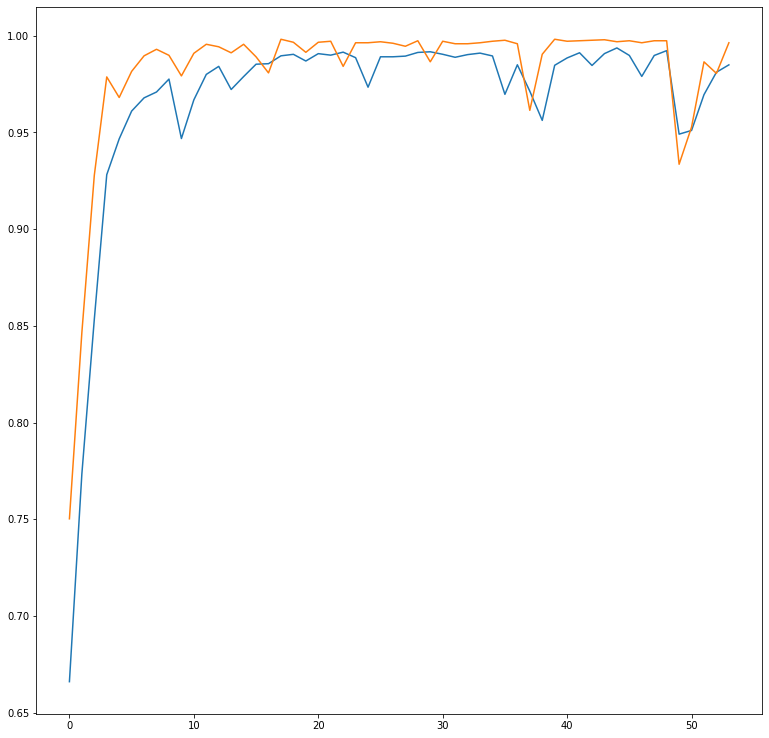

In [ ]:
plt.figure(figsize=(13,13))
plt.plot(accs)
plt.plot(vals)

In [ ]:
from sklearn.metrics import confusion_matrix
y_predict=model_multi2.predict(x_test_list)
conf_matr=confusion_matrix(np.argmax(y_test_list,axis=-1),np.argmax(y_predict,axis=-1))

In [ ]:
for i in range(7):
    conf_matr[i,i]=0

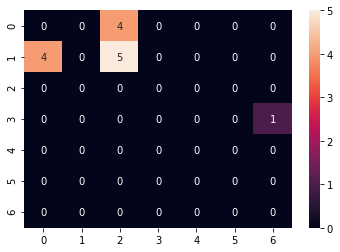

In [ ]:
import seaborn as sns
sns.heatmap(conf_matr,annot=True)

# Preprocesado/NORMALIZACION de datos iniciales (valores pixeles)


## recopilacion funciones importante

Si queremos cargar un solo telescopio nos basta con load_data, si queremos cargr varios telescopios debemos usar load_dataset porque tenemso que comprobar que los y todo eso se cogen de forma correcta para todos los telescopios

In [ ]:
#nos falta cargar lo datos.
#esto puede ser un poco triky porque necesitamos cargar para los mismos 4 telescopios, 
#de diferentes carpetas y varias RUNS (si no todas)
def load_data(npy_dir,tels=None,runs=None,indices_runs=None,only_names=True,ending=".npy",return_with_labels=False,test_size=0.2):
    #aplicamos regular expresions para extraer los documentos deseados
    #usamos glob
    #si no pasamos ni los tesls ni las runs, deolvemos todos los arichivos
    #es poco optimo este uso de glob, pero es mas flexivo porque le puedo pasar los tels concretos y los runs concretos
    #si es return sin labels, nos devuelve todo, sin separar siquiera

    lista=[]
    if ((type(tels)==list) or (type(tels)==np.ndarray))and (len(tels)!=1):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            for j in runs:
                regex=f"{npy_dir}/*_tel_{i}_run_{str(j).zfill(2)}_?{ending}"
                aux=glob.glob(regex)
                if aux:
                    lista.extend(aux)
                else:
                    #si no lo encuentra entonces nos saldra mal la cosa
                    print("ERROR")
                    print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")

    elif (type(runs)==list) or (type(runs)==np.ndarray):
        #si no es una lista pero las runs si entonces seguimos con esto
        for j in runs:
            regex=f"{npy_dir}/*_tel_{tels}_run_{str(j).zfill(2)}_?{ending}"
            aux=glob.glob(regex)
            if aux:
                lista.extend(aux)
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir)} no se encuentra el {os.path.basename(regex)}.")
    elif (tels==None) and (runs==None):
        #y sino por ultimo esto
        regex=f"{npy_dir}/*_tel_*_run_*_?{ending}"
        aux=glob.glob(regex)
        if aux:
            lista.extend(aux)
    else:
        print("ERROR")
    if only_names:
        return lista
    else:
        if indices_runs!=None:
            if return_with_labels:
                lista_npy=np.load(lista[0])[indices_runs[0]]
                for m,k in enumerate(lista[1:]):
                    lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
                return x_train,x_test,y_train,y_test
            else:
                lista_npy=np.load(lista[0])[indices_runs[0]]
                for m,k in enumerate(lista[1:]):
                    lista_npy=np.concatenate((lista_npy,np.load(k)[indices_runs[m+1]]),axis=0)
                return lista_npy
        else:
            if return_with_labels:
                lista_npy=np.load(lista[0])
                for m,k in enumerate(lista[1:]):
                    lista_npy=np.concatenate((lista_npy,np.load(k)),axis=0)
                x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
                return x_train,x_test,y_train,y_test


            else:
                lista_npy=np.load(lista[0])
                for m,k in enumerate(lista[1:]):
                    lista_npy=np.concatenate((lista_npy,np.load(k)),axis=0)
                return lista_npy


In [ ]:
def get_common_events(npy_dir_base,tels=None,run=None):
    #esta funcion nos sirve para obtener los indices de eventos comunes tal que 
    #esto es necesario para que las imagenes sean del mismo evento

    #TENEMOS QUE MIRAR PARA UNA RUN, TODOS LOS TELESCOPIOS QUE NOS INTERESEN,
    #SIN IMPORTAR EL ELEMENTO, SOLO LOS TELESCOPIOS DE LA RUN Y EL EMENTO QUE TOQUE
    lista=[]
    if (type(tels)==list) or (type(tels)==np.ndarray):
        #primero miramos a ver si es una lista los telescopios
        for i in tels:
            regex=f"{npy_dir_base}/id_eventos_*_tel_{i}_run_{str(run).zfill(2)}.npy"
            aux=glob.glob(regex)
            if aux:
                lista.append(np.load(aux[0]))
            else:
                #si no lo encuentra entonces nos saldra mal la cosa
                print("ERROR")
                print(f"Para {os.path.basename(npy_dir_base)} no se encuentra el {os.path.basename(regex)}.")
    else:
        print("ERROR")
        return None
    if len(tels)==1:
        eventos_comunes=lista[0]
    else:
        sets=[set(i) for i in lista]
        #devolvemos una lista de los INDICES de los eventos que SON COMUNES y podemos coger
        eventos_comunes=sorted(list(sets[0].intersection(*sets[1:])))
        del sets
    indices_master=[]
    for i,j in enumerate(tels):
        indices=[]
        for k in eventos_comunes:
            indices.append(np.where(lista[i]==k)[0][0])
        indices_master.append(np.array(indices))
    return np.array(indices_master)




In [ ]:
def load_dataset(base_dir,pre_name_folders="npy_",telescopios=None,list_runs=None,elementos=None,test_size=0.2,normalizacion_mal=False):
    #telescopios deb ser una lista , aunque solo haya uno 1
    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    eventos_elementos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir}/{pre_name_folders}{j}"
        eventos_runs=[]
        for l,k in enumerate(list_runs):
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            eventos_runs.append(aux_events)
        eventos_elementos.append(eventos_runs)

    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir}/{pre_name_folders}{j}"
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
            if normalizacion_mal:
                maximo_aux=np.amax(data_aux)
            else:
                maximo_aux=1
            if (i==0) :
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.zeros(label_size)
                data=data_aux.copy()/maximo_aux
                del data_aux
            else:
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.concatenate((labels,np.ones(label_size)*i),axis=0)
                data=np.concatenate((data,data_aux/maximo_aux),axis=0)
                del data_aux
        #print(data.shape)
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            labels=tf.keras.utils.to_categorical(labels)
            x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
            del data,labels
            y_train_list=y_train.copy()
            y_test_list=y_test.copy()
            x_train_list.append(x_train.copy())
            x_test_list.append(x_test.copy())
            #del y_train,y_test
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train.copy())
            x_test_list.append(x_test.copy())
        #del x_train,x_test

    if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
        print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
        return None
    else:
        print("EXITO")
        if len(telescopios)==1:
            return x_train_list[0],x_test_list[0],y_train_list,y_test_list
        else:
            return x_train_list,x_test_list,y_train_list,y_test_list



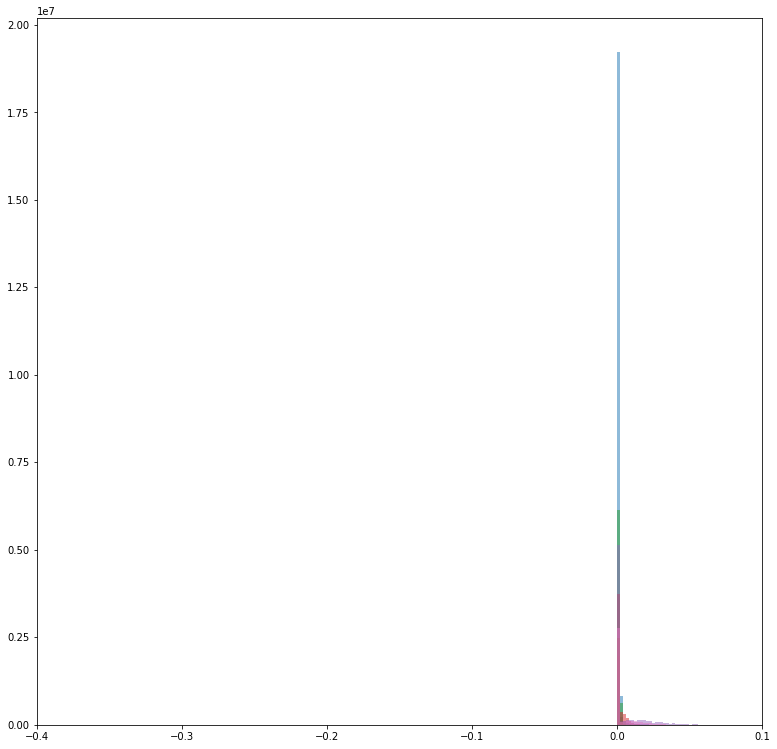

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"



elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']

telescopios=[4]#,5,6,11]
list_runs=np.arange(1,3)

datos=[]
plt.figure(figsize=(13,13))
for i,j in enumerate(elementos):
    dir_aux=f"{npy_base}/npy_{j}"
    datos_aux=load_data(dir_aux,tels=4,runs=list_runs,only_names=False,return_with_labels=False)
    datos.append(datos_aux)
    
    plt.hist(datos_aux.flatten()/np.amax(datos_aux),bins=500,alpha=0.5)
    plt.xlim([-0.4,0.1])

In [ ]:
tot=[i.shape[0] for i in datos]

In [ ]:
sum(tot)

9405

gamma (9993,) 474.72087461222856 319.94522274984496 1746.9
electron (993,) 271.2205438066465 283.3635991552014 1583.5
proton (3403,) 75.46764619453423 84.401677635757 1028.5
helium (2441,) 54.99541171650962 43.46961950599988 516.2
iron (3523,) 25.220408742548965 15.143385484484932 118.1
nitrogen (1381,) 43.809341057204925 42.9597569419339 1082.1
silicon (1794,) 36.00680044593088 23.591874262856386 293.5


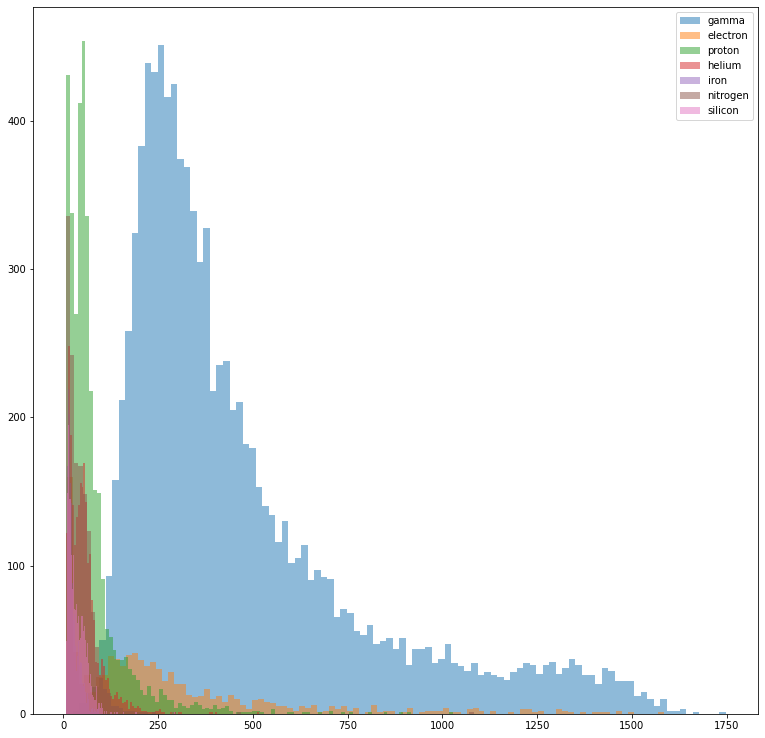

In [ ]:
plt.figure(figsize=(13,13))

for i,j in enumerate(datos):
    a=j.max(axis=-1).max(axis=-1)
    print(elementos[i],a.shape,a.mean(),a.std(),a.max())
    plt.hist(a,bins=100,alpha=0.5,histtype="stepfilled",label=elementos[i])
    plt.legend()
    #plt.xlim([-0.04,10])

In [ ]:
datos_stak=np.concatenate(datos,axis=0)
datos_stak.shape

(23528, 55, 93)

In [ ]:
datos_stak_max=datos_stak.max(axis=-1).max(axis=-1)
datos_stak_max.shape

(23528,)

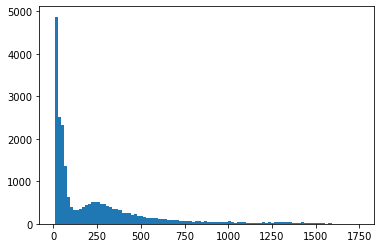

In [ ]:
plt.hist(datos_stak_max,bins=100);

# Normalizacion inicial input (AUTOENCODER):

Tenemos un problemon y es el gran rango de valores que se le puede dar a la red, si este input no se normaliza correctamente, la red no será capaz de funcionar bien.
El problema es que para unas tenemos un maximo muy grande y para otras tenemso uno muy pequeño, pero no tiene una buena perspectiva de como escalar el input.

Vamos a ver si un autoencoder es capaz de hacer la tarea de normalizar.

In [ ]:
#primero cargamos los datos, los primeros normales, los segundos (output) con la normalizacion guay, 
#una diferente para cada elemento
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

x_train,x_test,_,_=load_dataset(npy_base,telescopios=[4],list_runs=[9,10,11],test_size=0.2)
y_train,y_test,_,_=load_dataset(npy_base,telescopios=[4],list_runs=[9,10,11],test_size=0.2,normalizacion_mal=True)

EXITO
EXITO


In [ ]:
#autoencoder muy sencillo
input_shape=x_train[1].shape
iner_dim=10**2
model=tf.keras.Sequential()
#encoder
model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(iner_dim,activation="relu"))
model.add(tf.keras.layers.Dense(iner_dim//1.5,activation="relu"))
 
#decoder
model.add(tf.keras.layers.Dense(iner_dim,activation="relu"))
model.add(tf.keras.layers.Dense(input_shape[0]*input_shape[1],activation="sigmoid"))
model.add(tf.keras.layers.Reshape(target_shape=input_shape))
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 5115)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               511600    
_________________________________________________________________
dense_9 (Dense)              (None, 66)                6666      
_________________________________________________________________
dense_10 (Dense)             (None, 100)               6700      
_________________________________________________________________
dense_11 (Dense)             (None, 5115)              516615    
_________________________________________________________________
reshape_2 (Reshape)          (None, 55, 93, 1)         0         
Total params: 1,041,581
Trainable params: 1,041,581
Non-trainable params: 0
____________________________________________

In [ ]:
hist=model.fit(x_train,y_train,epochs=30,batch_size=64,validation_data=(x_test,x_test))

Epoch 1/30
118/118 [==============================] - 4s 6ms/step - loss: 0.1506 - val_loss: 8.5590
Epoch 2/30
118/118 [==============================] - 1s 4ms/step - loss: 0.0134 - val_loss: 6.2448
Epoch 3/30
118/118 [==============================] - 1s 4ms/step - loss: 0.0122 - val_loss: 5.6627
Epoch 4/30
118/118 [==============================] - 0s 4ms/step - loss: 0.0118 - val_loss: 4.8621
Epoch 5/30
118/118 [==============================] - 0s 4ms/step - loss: 0.0117 - val_loss: 5.1005
Epoch 6/30
118/118 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 4.8026
Epoch 7/30
118/118 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 5.0271
Epoch 8/30
118/118 [==============================] - 1s 4ms/step - loss: 0.0114 - val_loss: 4.5562
Epoch 9/30
118/118 [==============================] - 1s 4ms/step - loss: 0.0114 - val_loss: 4.5750
Epoch 10/30
118/118 [==============================] - 1s 4ms/step - loss: 0.0113 - val_loss: 4.6808

In [ ]:
plt.figure(figsize=(11,16))
k=110
for i in range(6):
    predict=model.predict(x_test[i+k][np.newaxis,...])
    plt.subplot(6,3,i*3+1)
    plt.imshow(x_test[i+k][:,:,0])
    plt.title("Ground truth",fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(6,3,i*3+2)
    plt.imshow(predict[0][:,:,0])

    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted",fontsize=12)
    ax=plt.subplot(6,3,i*3+3)
    plt.imshow(abs(x_test[i+k][:,:,0]-predict[0][:,:,0]),vmax=np.amax(x_test[i+k][:,:,0]))

    #plt.xticks([])
    #plt.yticks([])
    #otra forma de ponerlo
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.title("Diference (in same scale)",fontsize=12)


plt.tight_layout()

In [ ]:
#tenemos que añadirle una dimension a los datos, el channel
x_train1=x_train[:,1:,3:]
x_test1=x_test[:,1:,3:]
y_train1=y_train[:,1:,3:]
y_test1=y_test[:,1:,3:]
#este cambio lo hacemos para que la dimension sea par y lueg oen todo el tema de los poolings no tengamos perdida de dimensiones, 
#estamos sacrificando solo una columna no pasa na

In [ ]:
input_shape

(55, 93, 1)

In [ ]:
#creamos un autoencoder convolucional por partes
input_shape=x_train[1].shape
input_img = tf.keras.Input(shape=input_shape)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)

model_encoder=tf.keras.Model(inputs=input_img,outputs=encoded)


# at this point the representation is (4, 4, 8) i.e. 128-dimensional
input_autoencoder=tf.keras.Input(shape=input_shape)
x=model_encoder(input_autoencoder)
x = tf.keras.layers.Conv2D(12, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x= tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)
#x = tf.keras.layers.Flatten()(x)
decoded=tf.keras.layers.LocallyConnected2D(1,(2,4),activation="relu",padding="valid")(x)
#decoded=tf.keras.layers.Reshape(input_shape)
#x = tf.keras.layers.Flatten()(x)
#x = tf.keras.layers.Dense(input_shape[0]*input_shape[1])(x)
#decoded=tf.keras.layers.Reshape(target_shape=input_shape)(x)


autoencoder = tf.keras.Model(input_autoencoder, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 55, 93, 1)]       0         
_________________________________________________________________
model_6 (Functional)         (None, 7, 12, 64)         55744     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 12, 120)        69240     
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 24, 120)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 24, 16)        17296     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 24, 16)        2320      
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 28, 48, 16)        0   

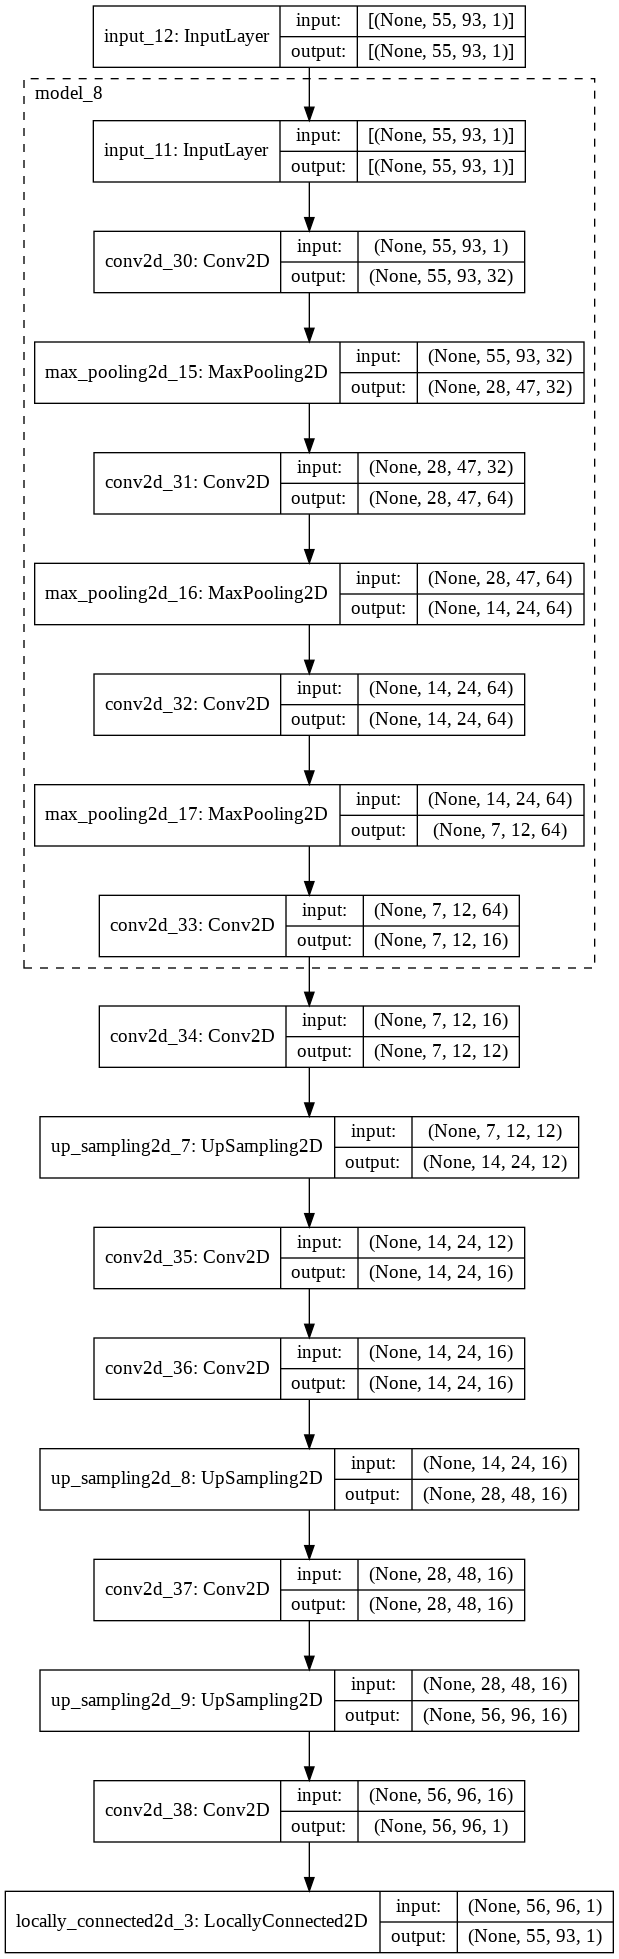

In [ ]:
tf.keras.utils.plot_model(autoencoder, "prueba_1.png", show_shapes=True,expand_nested=True)

In [ ]:
hist3=autoencoder.fit(x_train,y_train,epochs=23,batch_size=64,validation_data=(x_test,y_test))
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
autoencoder.save(f"{npy_base}/autoencoder_separado.h5")
model_encoder.save(f"{npy_base}/encoder_separado.h5")

Epoch 1/23
178/178 [==============================] - 33s 183ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 2/23
178/178 [==============================] - 32s 179ms/step - loss: 0.0114 - val_loss: 0.0112
Epoch 3/23
178/178 [==============================] - 32s 180ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 4/23
178/178 [==============================] - 32s 179ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 5/23
178/178 [==============================] - 32s 179ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 6/23
178/178 [==============================] - 32s 180ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 7/23
178/178 [==============================] - 32s 180ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 8/23
178/178 [==============================] - 32s 179ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 9/23
178/178 [==============================] - 32s 180ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 10/23
178/178 [==============================] - 32s 180ms/step - l

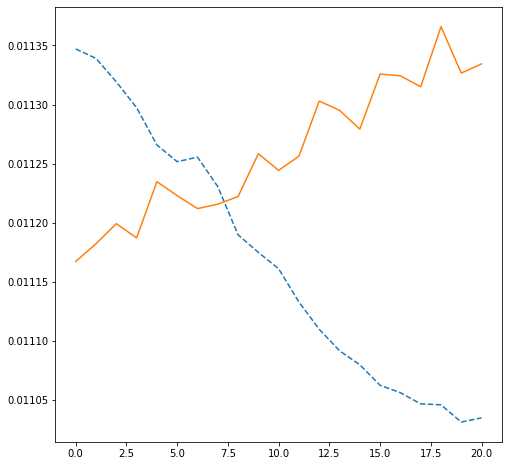

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(hist3.history["loss"][2:],"--")
plt.plot(hist3.history["val_loss"][2:])

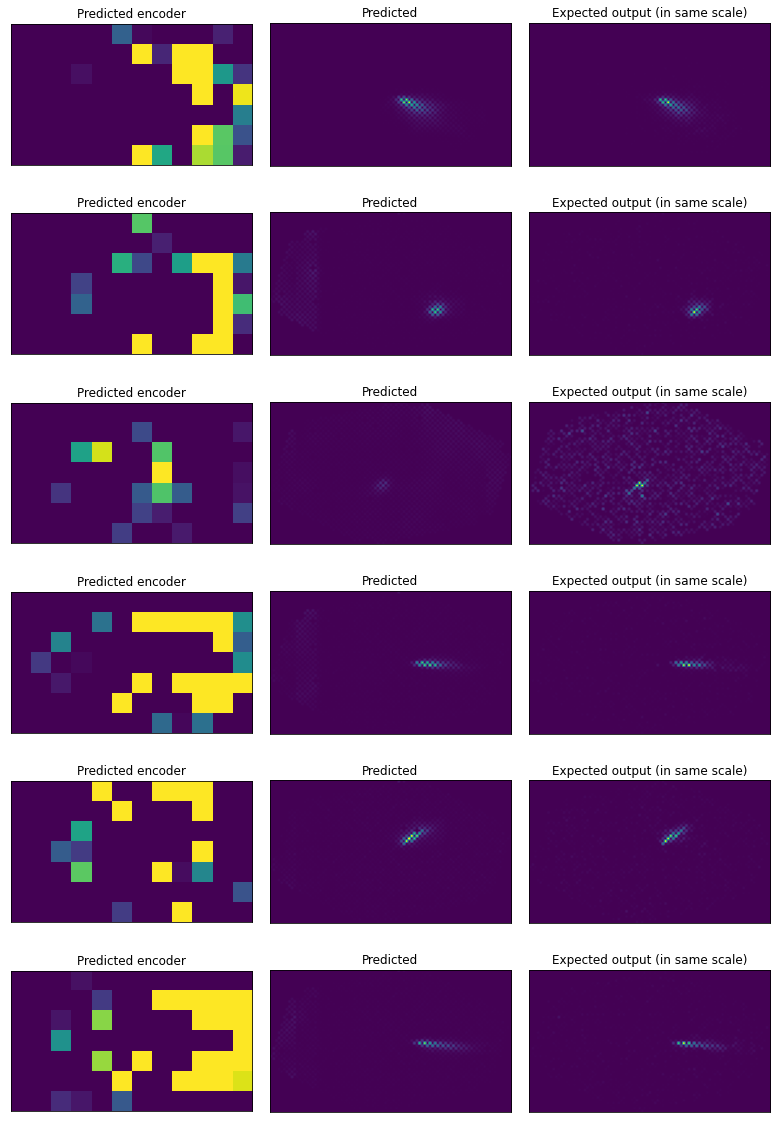

In [ ]:
plt.figure(figsize=(11,16))
k=389

for i in range(6):
    predict=autoencoder.predict(x_test[i+k][np.newaxis,...])
    predict2=model_encoder.predict(x_test[i+k][np.newaxis,...])

    """
    plt.subplot(6,3,i*3+1)
    plt.imshow(x_test[i+k][:,:,0])
    plt.title("Input",fontsize=12)
    plt.xticks([])
    plt.yticks([])
    """    
    max=np.amax(y_test[i+k][:,:,0])

    plt.subplot(6,3,i*3+1)
    plt.imshow(predict2[0][:,:,0],vmin=0,vmax=max)
    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted encoder",fontsize=12)



    plt.subplot(6,3,i*3+2)
    plt.imshow(predict[0][:,:,0],vmin=0,vmax=max)
    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted",fontsize=12)

    ax=plt.subplot(6,3,i*3+3)
    plt.imshow(y_test[i+k][:,:,0],vmax=max)

    #plt.xticks([])
    #plt.yticks([])
    #otra forma de ponerlo
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.title("Expected output (in same scale)",fontsize=12)


plt.tight_layout()

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"
autoencoder=tf.keras.models.load_model(f"{npy_base}/autoencoder_bien.h5")

#autoencoder.save(f"{npy_base}/autoencoder_bien.h5")

In [ ]:
import cv2

In [ ]:
a=cv2.GaussianBlur(x_train[6],(3,3),1)

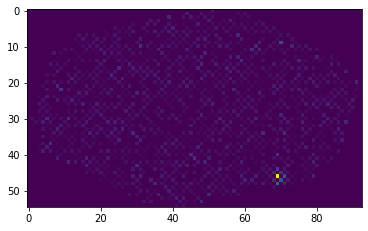

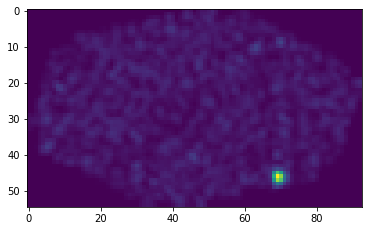

In [ ]:
plt.imshow(x_train[6][:,:,0])
plt.figure()
plt.imshow(a)

In [ ]:
np.ptp()

1. X = (X - X.mean) / X.std
2. X /= 255. # (based on formula: (X - min) / (max - min) which can converge data into [0, 1].)
3. X = 2 * (X - min) / (max - min) - 1 # converge into [-1, 1]


Broadly speaking, the reason we normalize the images is to make the model converge faster. When the data is not normalized, the shared weights of the network have different calibrations for different features, which can make the cost function to converge very slowly and ineffectively. Normalizing the data makes the cost function much easier to train.

Exactly which normalization method you choose depends on the data that you are dealing with and the assumptions you make about that data. All the above three normalization methods are based on two ideas, that are, centering and scaling. Method 2. involves only scaling the data into a particular range. This makes sure that the scale of the various features is in a similar range and hence gives stable gradients. Method 1. involves centering the data around the mean datapoint and then dividing each dimension of the datapoint with its standard deviation so that all the dimensions hold equal importance for the learning algorithm. This normalization is more effective when you have a reason to believe that different dimensions in the data have vastly different range. Bringing all the dimensions in the same range thus make sharing of the parameters effective. Method 3 can also be seen as somewaht doing the sam job as method 1.

## Como de bien está este preprocesado???

In [ ]:
#cargamos los datos
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

x_train,x_test,_,_=load_dataset(npy_base,telescopios=[4],list_runs=[7,8,9],test_size=0.2)
y_train,y_test,_,_=load_dataset(npy_base,telescopios=[4],list_runs=[7,8,9],test_size=0.2,normalizacion_mal=True)

EXITO
EXITO


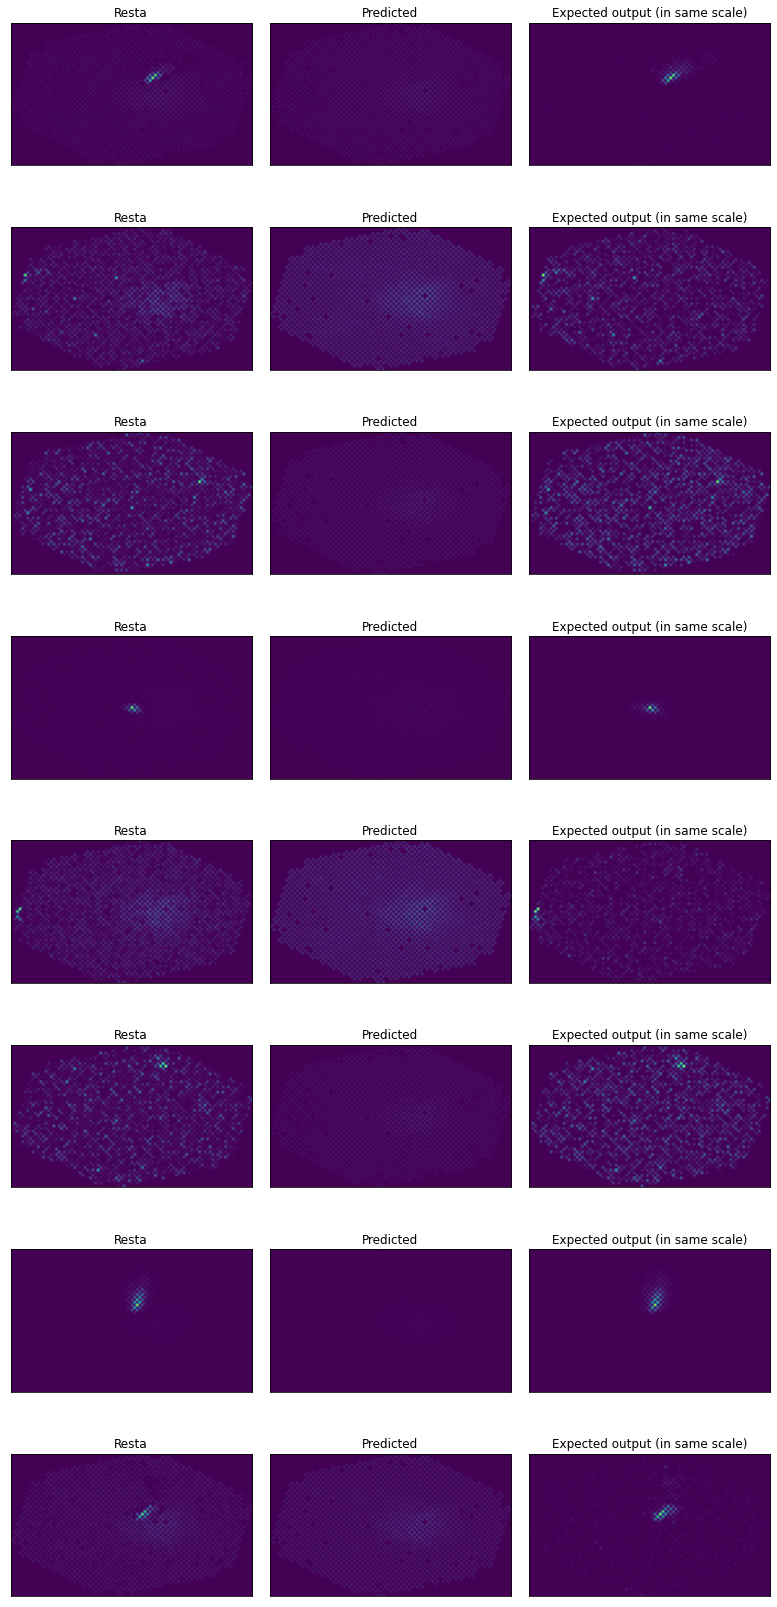

In [ ]:
plt.figure(figsize=(11,23))
k=3
for i in range(8):
    predict=autoencoder.predict(x_test[i+k][np.newaxis,...])
    max=np.amax(y_test[i+k][:,:,0])
    #predict[predict<0]=0
    plt.subplot(8,3,i*3+1)
    plt.imshow(abs(predict[0][:,:,0]-y_test[i+k][:,:,0]),vmin=0,vmax=max)
    plt.title("Resta",fontsize=12)
    plt.xticks([])
    plt.yticks([])


    plt.subplot(8,3,i*3+2)
    plt.imshow(predict[0][:,:,0],vmin=0,vmax=max)
    plt.xticks([])
    plt.yticks([])
    plt.title("Predicted",fontsize=12)

    ax=plt.subplot(8,3,i*3+3)
    plt.imshow(y_test[i+k][:,:,0],vmax=max)

    #plt.xticks([])
    #plt.yticks([])
    #otra forma de ponerlo
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.title("Expected output (in same scale)",fontsize=12)


plt.tight_layout()

In [ ]:
predicted=autoencoder.predict(x_train,batch_size=64)
predicted[predicted<0]=0

In [ ]:
(predicted==0).shape

(11341, 55, 93, 1)

In [ ]:
plt.figure(figsize=(13,13))
#plt.hist(x_train.flatten(),alpha=0.3,bins=50,label="x_train");
plt.hist(y_train,alpha=0.8,bins=50,label="y_train");
plt.figure(figsize=(13,13))
plt.hist(a,alpha=0.8,bins=50,label="predicted");
plt.legend()

#crear clasificador con el autoencoder primero



In [ ]:
def create_model(num_inputs,dims_inputs,num_class,pre_model=None,pre_proces_model=None,copy_pre=False):
#una funcion para crear el modelo con diferentes parámetros

    def block(input_lay):
        #x=tf.keras.layers.Lambda(lambda_func)(input_lay)
        x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(input_lay)
        #x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
        #x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Flatten()(x)
        #x=tf.keras.layers.Dropout(0.3)(x)
        #x=tf.keras.layers.Dense(25,activation="relu")(x)
        return x
    #creamos los diferentes inputs para nuestra funcion
    if len(dims_inputs)==1:
        dims_inputs=[dims_inputs[0] for _ in range(num_inputs)]
    inputs=[]
    for i in range(num_inputs):
        inputs.append(tf.keras.Input(shape=dims_inputs[i]))

    if not pre_model:
        #si no se nos pasa un modelo para el input lo que hacemos es crearlo
        #a cada input le vamos a aplicar la misma capa de feature extraction

        output_clasify=[]
        for j in inputs:
            output_clasify.append(block(pre_proces_model(j)))

    elif pre_model:
        #en teoria es una lista de modelos, pero si la lista de solo uno, vamos a tomar ese para todas las ramas
        output_clasify=[]
        if len(pre_model)==1:
            if copy_pre:
                pesos=pre_model[0].get_weights()
                pre_model_new=[tf.keras.models.clone_model(pre_model[0]) for _ in range(num_inputs)]
                for i in range(num_inputs):
                    pre_model_new[i].set_weights(pesos)
                    pre_model_new[i]._name=f"Feature_extraction_{i+1}"
            else:
                pre_model_new=[pre_model[0] for _ in range(num_inputs)]
            for i,j in enumerate(inputs):
                output_clasify.append(pre_model_new[i](j))
        else:
            for i,j in enumerate(inputs):
                output_clasify.append(pre_model[i](j))
    if num_inputs==1:
        end_layer=tf.keras.layers.Dense(55,activation="relu")(output_clasify[0])
    else:
        end_layer=tf.keras.layers.Concatenate()(output_clasify)
        end_layer=tf.keras.layers.Dense(32,activation="relu")(end_layer)
    end_layer=tf.keras.layers.Dropout(0.3)(end_layer)
    end_layer=tf.keras.layers.Dense(15,activation="relu")(end_layer)
    end_layer=tf.keras.layers.Dropout(0.3)(end_layer)
    end_layer=tf.keras.layers.Dense(11,activation="relu")(end_layer)
    end_layer=tf.keras.layers.Dense(num_class,activation="softmax")(end_layer)
    model=tf.keras.Model(inputs=inputs,outputs=end_layer,name="prueba_red")
    return model

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"

#creamos el model de zero
#tenemos 4 inputs
telesc=4
input1=tf.keras.Input(shape=(55,93,1))
input2=tf.keras.Input(shape=(55,93,1))
input3=tf.keras.Input(shape=(55,93,1))
#input4=tf.keras.Input(shape=(55,93,1))

autoencoder=tf.keras.models.load_model(f"{npy_base}/autoencoder_bien.h5")
autoencoder.trainable=False
#entran los 4 inputs y nos dan 4 outputs diferentes

output1=autoencoder(input1)
output2=autoencoder(input2)
output3=autoencoder(input3)
#output4=autoencoder(input4)

#ahora los outputs los procesamos tal que todos se procesan por el mismo submodelo
aux_input=tf.keras.Input(shape=(55,93,1))
x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(aux_input)
#x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
#x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Flatten()(x)
submodel_conv=tf.keras.Model(inputs=aux_input,outputs=x)


final_output1=submodel_conv(output1)
final_output2=submodel_conv(output2)
final_output3=submodel_conv(output3)
#final_output4=submodel_conv(output4)

end_layer=tf.keras.layers.concatenate([final_output1,final_output2,final_output3])
end_layer=tf.keras.layers.Dense(70,activation="relu")(end_layer)
end_layer=tf.keras.layers.Dense(7,activation="softmax")(end_layer)
model=tf.keras.Model(inputs=[input1,input2,input3],outputs=end_layer,name="prueba_red")

Model: "prueba_red"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
model_18 (Functional)           (None, 55, 93, 1)    77020       input_5[0][0]                    
                                                                 input_6[0][0]           

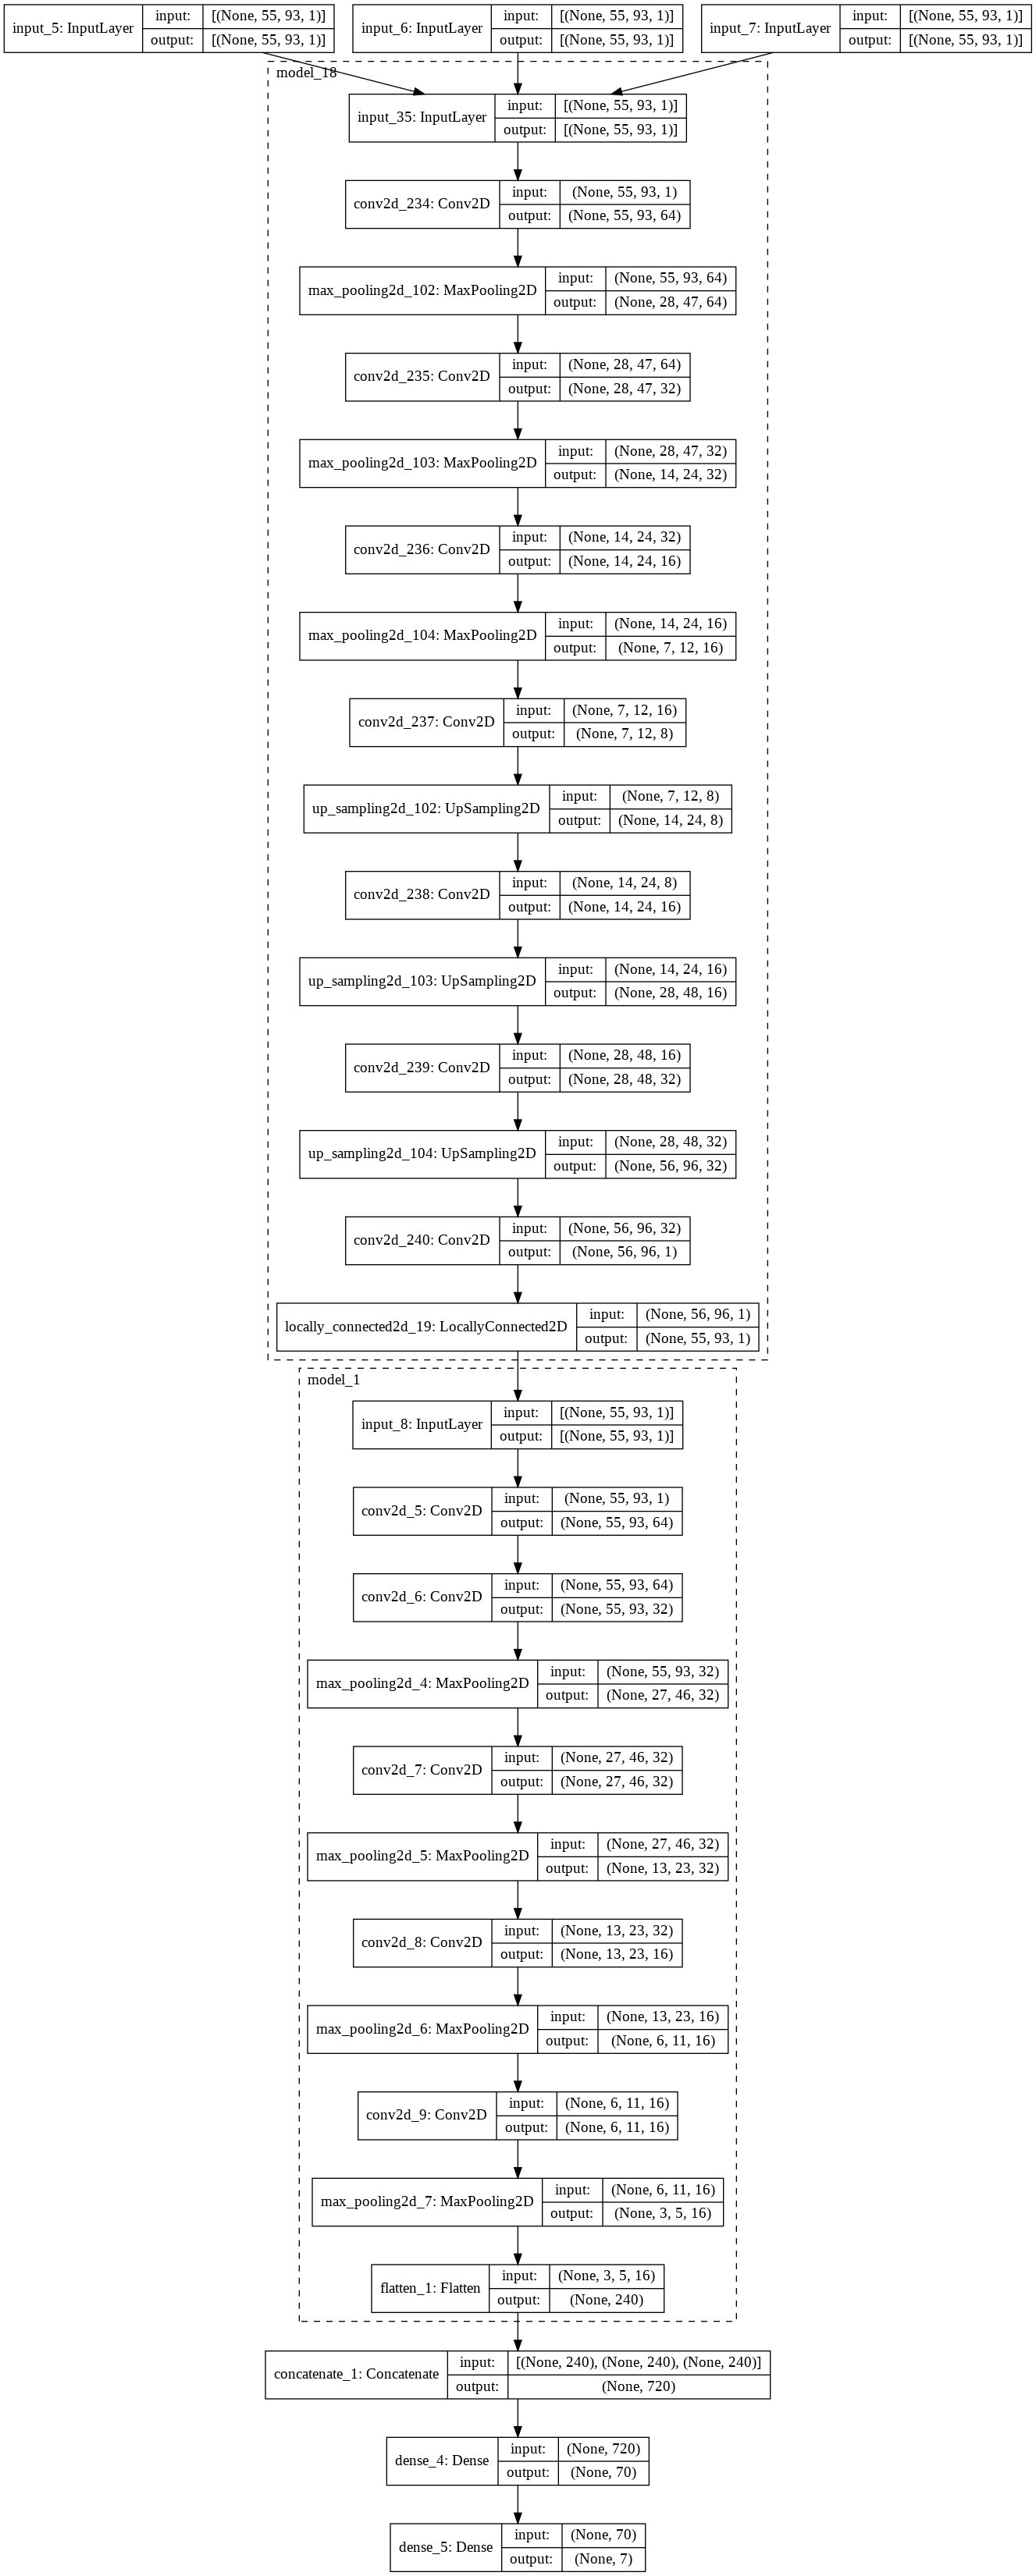

In [ ]:
model.summary()
tf.keras.utils.plot_model(model, "prueba_1.png", show_shapes=True,expand_nested=True)

In [ ]:
historia_master2=[]

model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"#/npy_elementos_tel_1"
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6)
elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
telescopios=[4,5,6]
for n in range(1,18,4):
    #no llegamos a mayores runs por el IRON, hay que arreglar eso
    list_runs=np.arange(n,n+2)
    print(f"Para las runs: {list_runs}")
    x_train_list,x_test_list,y_train_list,y_test_list=load_dataset(npy_base,telescopios=telescopios,list_runs=list_runs)
    hist2=model.fit(x_train_list,y_train_list,epochs=30,batch_size=64,validation_data=(x_test_list,y_test_list),callbacks=[stop])
    historia_master2.append(hist2)
    autoencoder.trainable=True


Para las runs: [1 2]
EXITO
Epoch 1/30
83/83 [==============================] - 701s 3s/step - loss: 1.3914 - accuracy: 0.5989 - val_loss: 0.7965 - val_accuracy: 0.7197
Epoch 2/30
83/83 [==============================] - 34s 411ms/step - loss: 0.8150 - accuracy: 0.7190 - val_loss: 0.7133 - val_accuracy: 0.7296
Epoch 3/30
83/83 [==============================] - 34s 413ms/step - loss: 0.6546 - accuracy: 0.7509 - val_loss: 0.6296 - val_accuracy: 0.7563
Epoch 4/30
83/83 [==============================] - 34s 411ms/step - loss: 0.5867 - accuracy: 0.7583 - val_loss: 0.6141 - val_accuracy: 0.7449
Epoch 5/30
83/83 [==============================] - 34s 410ms/step - loss: 0.5610 - accuracy: 0.7708 - val_loss: 0.5772 - val_accuracy: 0.7624
Epoch 6/30
83/83 [==============================] - 34s 411ms/step - loss: 0.5114 - accuracy: 0.7959 - val_loss: 0.5735 - val_accuracy: 0.7647
Epoch 7/30
83/83 [==============================] - 34s 406ms/step - loss: 0.5249 - accuracy: 0.7921 - val_loss: 0.61

# Estamos dandole demasiada informacion a nuestra red ?

Vamos a dividir por diferentes numeros dependiendo del elemento, de esta manera,
le indicamos de alguna manera cual es cual, pero no por la media etc...

In [ ]:
def load_dataset_mal(base_dir,pre_name_folders="npy_",telescopios=None,list_runs=None,elementos=None,test_size=0.2,normalizacion_mal=False,ponderaciones=None):
    #telescopios deb ser una lista , aunque solo haya uno 1
    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    eventos_elementos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir}/{pre_name_folders}{j}"
        eventos_runs=[]
        for l,k in enumerate(list_runs):
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            eventos_runs.append(aux_events)
        eventos_elementos.append(eventos_runs)

    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]
    prueba=ponderaciones
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir}/{pre_name_folders}{j}"
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
            if normalizacion_mal:
                maximo_aux=prueba[i] #np.amax(data_aux)
            else:
                maximo_aux=1
            if (i==0) :
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.zeros(label_size)
                data=data_aux.copy()/maximo_aux
                del data_aux
            else:
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.concatenate((labels,np.ones(label_size)*i),axis=0)
                data=np.concatenate((data,data_aux/maximo_aux),axis=0)
                del data_aux
        #print(data.shape)
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            labels=tf.keras.utils.to_categorical(labels)
            x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
            del data,labels
            y_train_list=y_train.copy()
            y_test_list=y_test.copy()
            x_train_list.append(x_train.copy())
            x_test_list.append(x_test.copy())
            #del y_train,y_test
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train.copy())
            x_test_list.append(x_test.copy())
        #del x_train,x_test

    if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
        print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
        return None
    else:
        print("EXITO")
        if len(telescopios)==1:
            return x_train_list[0],x_test_list[0],y_train_list,y_test_list
        else:
            return x_train_list,x_test_list,y_train_list,y_test_list



In [ ]:
#primero cargamos los datos, los primeros normales, los segundos (output) con la normalizacion guay, 
#una diferente para cada elemento
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

x_train,x_test,y_train,y_test=load_dataset_mal(npy_base,telescopios=[4],list_runs=[9,10,11],test_size=0.2,normalizacion_mal=True)

EXITO


In [ ]:
def create_model(num_inputs,dims_inputs,num_class,pre_model=None,copy_pre=False):
#una funcion para crear el modelo con diferentes parámetros

    def block(input_lay):
        #x=tf.keras.layers.Lambda(lambda_func)(input_lay)
        x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(input_lay)
        x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
        x=tf.keras.layers.MaxPool2D((2,2))(x)
        x=tf.keras.layers.Flatten()(x)
        #x=tf.keras.layers.Dropout(0.3)(x)
        #x=tf.keras.layers.Dense(25,activation="relu")(x)
        return x
    #creamos los diferentes inputs para nuestra funcion
    if len(dims_inputs)==1:
        dims_inputs=[dims_inputs[0] for _ in range(num_inputs)]
    inputs=[]
    for i in range(num_inputs):
        inputs.append(tf.keras.Input(shape=dims_inputs[i]))

    if not pre_model:
        #si no se nos pasa un modelo para el input lo que hacemos es crearlo
        #a cada input le vamos a aplicar la misma capa de feature extraction

        output_clasify=[]
        for j in inputs:
            output_clasify.append(block(j))

    elif pre_model:
        #en teoria es una lista de modelos, pero si la lista de solo uno, vamos a tomar ese para todas las ramas
        output_clasify=[]
        if len(pre_model)==1:
            if copy_pre:
                pesos=pre_model[0].get_weights()
                pre_model_new=[tf.keras.models.clone_model(pre_model[0]) for _ in range(num_inputs)]
                for i in range(num_inputs):
                    pre_model_new[i].set_weights(pesos)
                    pre_model_new[i]._name=f"Feature_extraction_{i+1}"
            else:
                pre_model_new=[pre_model[0] for _ in range(num_inputs)]
            for i,j in enumerate(inputs):
                output_clasify.append(pre_model_new[i](j))
        else:
            for i,j in enumerate(inputs):
                output_clasify.append(pre_model[i](j))
    if num_inputs==1:
        end_layer=tf.keras.layers.Dense(55,activation="relu")(output_clasify[0])
    else:
        end_layer=tf.keras.layers.Concatenate()(output_clasify)
        end_layer=tf.keras.layers.Dense(55,activation="relu")(end_layer)
    end_layer=tf.keras.layers.Dropout(0.3)(end_layer)
    end_layer=tf.keras.layers.Dense(28,activation="relu")(end_layer)
    end_layer=tf.keras.layers.Dropout(0.3)(end_layer)
    end_layer=tf.keras.layers.Dense(14,activation="relu")(end_layer)
    end_layer=tf.keras.layers.Dense(num_class,activation="softmax")(end_layer)
    model=tf.keras.Model(inputs=inputs,outputs=end_layer,name="prueba_red")
    return model

Model: "prueba_red"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 55, 93, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 93, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 93, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 46, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 23, 32)        9

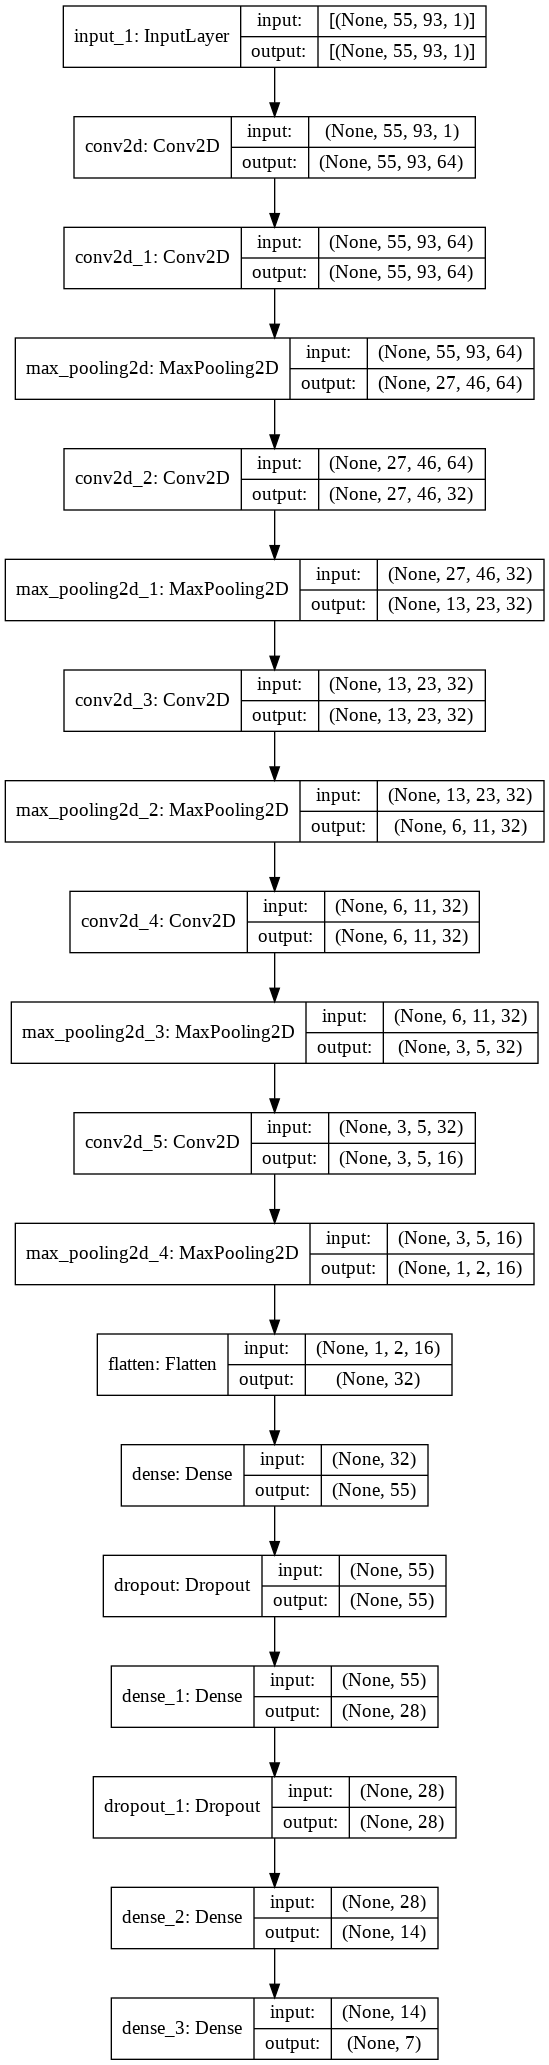

In [ ]:
model_multi=create_model(1,[(55,93,1)],7)
model_multi.summary()
tf.keras.utils.plot_model(model_multi, "prueba_1.png", show_shapes=True,expand_nested=True)

In [ ]:
#model_multi=create_model(1,[(55,93,1)],7)
model_multi.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6)
hist=model_multi.fit(x_train,y_train,epochs=50,batch_size=128,validation_data=(x_test,y_test),callbacks=[stop])


Epoch 1/50
89/89 [==============================] - 41s 78ms/step - loss: 1.6241 - accuracy: 0.3343 - val_loss: 1.1262 - val_accuracy: 0.6131
Epoch 2/50
89/89 [==============================] - 6s 62ms/step - loss: 1.1625 - accuracy: 0.5979 - val_loss: 0.9982 - val_accuracy: 0.6089
Epoch 3/50
89/89 [==============================] - 6s 62ms/step - loss: 0.9702 - accuracy: 0.6024 - val_loss: 0.7635 - val_accuracy: 0.6779
Epoch 4/50
89/89 [==============================] - 6s 62ms/step - loss: 0.7766 - accuracy: 0.6788 - val_loss: 0.5755 - val_accuracy: 0.7273
Epoch 5/50
89/89 [==============================] - 6s 62ms/step - loss: 0.6466 - accuracy: 0.7043 - val_loss: 0.5607 - val_accuracy: 0.7428
Epoch 6/50
89/89 [==============================] - 6s 63ms/step - loss: 0.5861 - accuracy: 0.7300 - val_loss: 0.5467 - val_accuracy: 0.7340
Epoch 7/50
89/89 [==============================] - 6s 62ms/step - loss: 0.5683 - accuracy: 0.7323 - val_loss: 0.5551 - val_accuracy: 0.7417
Epoch 8/50
8

In [ ]:
#le vamos a dar diferentes ponderaciones y vamos a registrar su validation acuracy
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10)
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

pesos=np.tril(np.ones(7))+np.ones(7)
val_acc={}
for i in pesos[:-1]:
    model_multi=create_model(1,[(55,93,1)],7)
    model_multi.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

    x_train,x_test,y_train,y_test=load_dataset_mal(npy_base,telescopios=[4],list_runs=[9,10,11],test_size=0.2,normalizacion_mal=True,ponderaciones=i)

    hist=model_multi.fit(x_train,y_train,epochs=50,batch_size=128,validation_data=(x_test,y_test),callbacks=[stop])
    val_acc[str(i)]=hist.history["val_accuracy"]

EXITO
Epoch 1/50
89/89 [==============================] - 6s 64ms/step - loss: 1.4750 - accuracy: 0.3993 - val_loss: 1.1215 - val_accuracy: 0.6258
Epoch 2/50
89/89 [==============================] - 6s 63ms/step - loss: 1.1467 - accuracy: 0.6106 - val_loss: 1.0432 - val_accuracy: 0.6350
Epoch 3/50
89/89 [==============================] - 6s 62ms/step - loss: 1.0514 - accuracy: 0.6250 - val_loss: 0.9284 - val_accuracy: 0.6413
Epoch 4/50
89/89 [==============================] - 6s 63ms/step - loss: 0.9488 - accuracy: 0.6296 - val_loss: 0.9001 - val_accuracy: 0.6547
Epoch 5/50
89/89 [==============================] - 6s 62ms/step - loss: 0.9458 - accuracy: 0.6229 - val_loss: 0.8737 - val_accuracy: 0.6635
Epoch 6/50
89/89 [==============================] - 6s 62ms/step - loss: 0.9072 - accuracy: 0.6435 - val_loss: 0.8685 - val_accuracy: 0.6589
Epoch 7/50
89/89 [==============================] - 6s 63ms/step - loss: 0.9316 - accuracy: 0.6333 - val_loss: 0.8713 - val_accuracy: 0.6575
Epoch 8

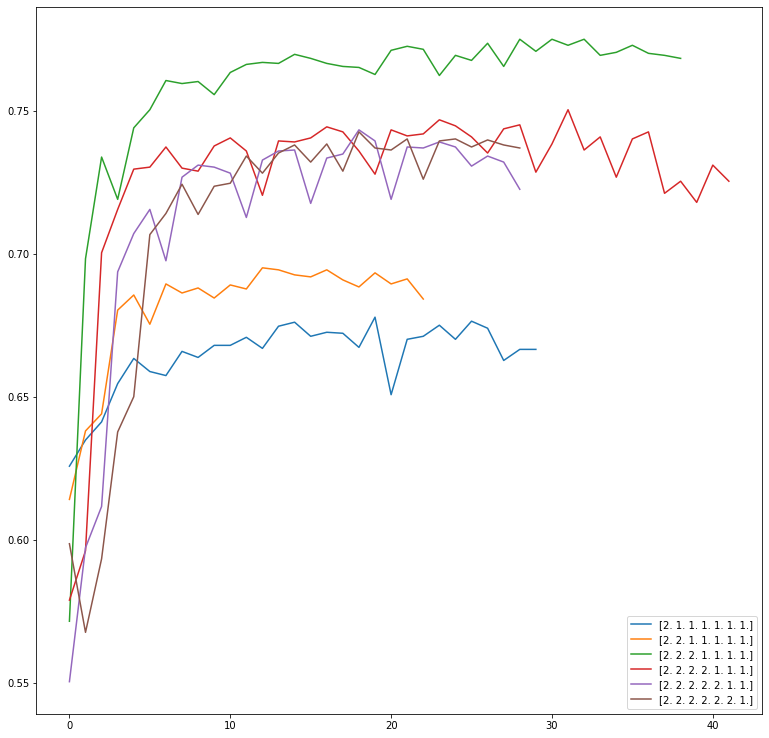

In [ ]:
a=list(val_acc.values())
plt.figure(figsize=(13,13))
for i in range(len(a)):
    plt.plot(a[i],label=list(val_acc.keys())[i])

plt.legend()

In [ ]:
a=[]
for i in range(7):
    b=np.ones(7)
    b[i]=2
    a.append(b)
a

[array([2., 1., 1., 1., 1., 1., 1.]),
 array([1., 2., 1., 1., 1., 1., 1.]),
 array([1., 1., 2., 1., 1., 1., 1.]),
 array([1., 1., 1., 2., 1., 1., 1.]),
 array([1., 1., 1., 1., 2., 1., 1.]),
 array([1., 1., 1., 1., 1., 2., 1.]),
 array([1., 1., 1., 1., 1., 1., 2.])]

In [ ]:
#le vamos a dar diferentes ponderaciones y vamos a registrar su validation acuracy
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10)
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

pesos=[]
for i in range(7):
    b=np.ones(7)
    b[i]=2
    pesos.append(b)

val_acc={}
for i in pesos[:-1]:
    model_multi=create_model(1,[(55,93,1)],7)
    model_multi.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

    x_train,x_test,y_train,y_test=load_dataset_mal(npy_base,telescopios=[4],list_runs=[9,10,11],test_size=0.2,normalizacion_mal=True,ponderaciones=i)

    hist=model_multi.fit(x_train,y_train,epochs=50,batch_size=128,validation_data=(x_test,y_test),callbacks=[stop])
    val_acc[str(i)]=hist.history["val_accuracy"]

EXITO
Epoch 1/50
89/89 [==============================] - 6s 65ms/step - loss: 1.4465 - accuracy: 0.4279 - val_loss: 1.1304 - val_accuracy: 0.6096
Epoch 2/50
89/89 [==============================] - 6s 62ms/step - loss: 1.1670 - accuracy: 0.6040 - val_loss: 1.0766 - val_accuracy: 0.6265
Epoch 3/50
89/89 [==============================] - 6s 62ms/step - loss: 1.1110 - accuracy: 0.6206 - val_loss: 0.9736 - val_accuracy: 0.6519
Epoch 4/50
89/89 [==============================] - 6s 63ms/step - loss: 0.9863 - accuracy: 0.6419 - val_loss: 0.9194 - val_accuracy: 0.6547
Epoch 5/50
89/89 [==============================] - 6s 63ms/step - loss: 0.9412 - accuracy: 0.6408 - val_loss: 0.9255 - val_accuracy: 0.6536
Epoch 6/50
89/89 [==============================] - 6s 64ms/step - loss: 0.9318 - accuracy: 0.6441 - val_loss: 0.8818 - val_accuracy: 0.6653
Epoch 7/50
89/89 [==============================] - 6s 63ms/step - loss: 0.9038 - accuracy: 0.6469 - val_loss: 0.8600 - val_accuracy: 0.6628
Epoch 8

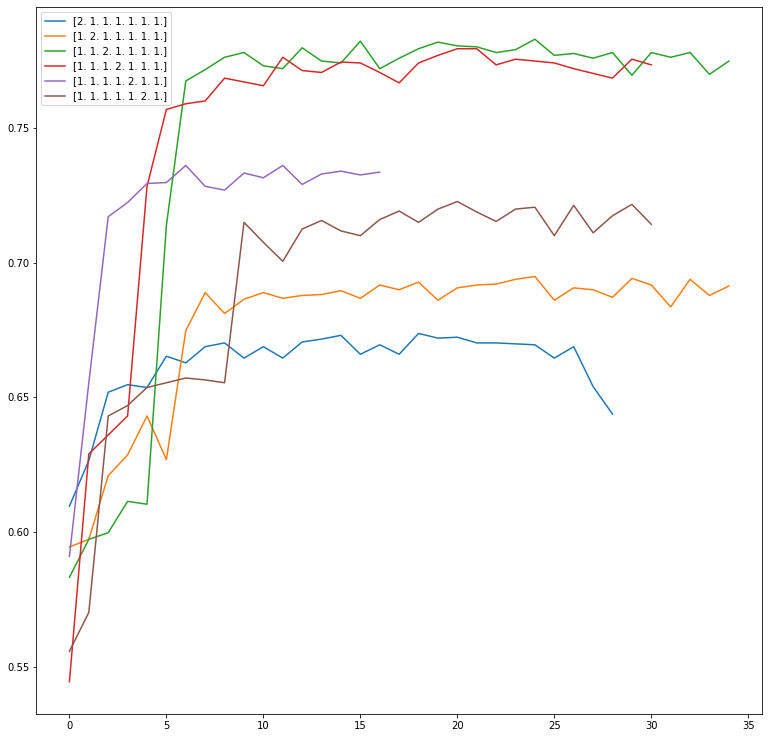

In [ ]:
a=list(val_acc.values())
plt.figure(figsize=(13,13))
for i in range(len(a)):
    plt.plot(a[i],label=list(val_acc.keys())[i])

plt.legend()

In [ ]:
a=[]
for i in range(1,7):
    b=np.ones(7)
    b[i-1]=2
    b[i]=3
    a.append(b)
a

[array([2., 3., 1., 1., 1., 1., 1.]),
 array([1., 2., 3., 1., 1., 1., 1.]),
 array([1., 1., 2., 3., 1., 1., 1.]),
 array([1., 1., 1., 2., 3., 1., 1.]),
 array([1., 1., 1., 1., 2., 3., 1.]),
 array([1., 1., 1., 1., 1., 2., 3.])]

EXITO
Epoch 1/50
89/89 [==============================] - 6s 65ms/step - loss: 1.5417 - accuracy: 0.2979 - val_loss: 1.1333 - val_accuracy: 0.6089
Epoch 2/50
89/89 [==============================] - 6s 63ms/step - loss: 1.1154 - accuracy: 0.5916 - val_loss: 1.0096 - val_accuracy: 0.6297
Epoch 3/50
89/89 [==============================] - 6s 62ms/step - loss: 1.0255 - accuracy: 0.6076 - val_loss: 0.8699 - val_accuracy: 0.6702
Epoch 4/50
89/89 [==============================] - 6s 62ms/step - loss: 0.8857 - accuracy: 0.6435 - val_loss: 0.8431 - val_accuracy: 0.6512
Epoch 5/50
89/89 [==============================] - 6s 63ms/step - loss: 0.8399 - accuracy: 0.6444 - val_loss: 0.8231 - val_accuracy: 0.6593
Epoch 6/50
89/89 [==============================] - 6s 64ms/step - loss: 0.8219 - accuracy: 0.6652 - val_loss: 0.7902 - val_accuracy: 0.6885
Epoch 7/50
89/89 [==============================] - 6s 63ms/step - loss: 0.7994 - accuracy: 0.6784 - val_loss: 0.7753 - val_accuracy: 0.6889
Epoch 8

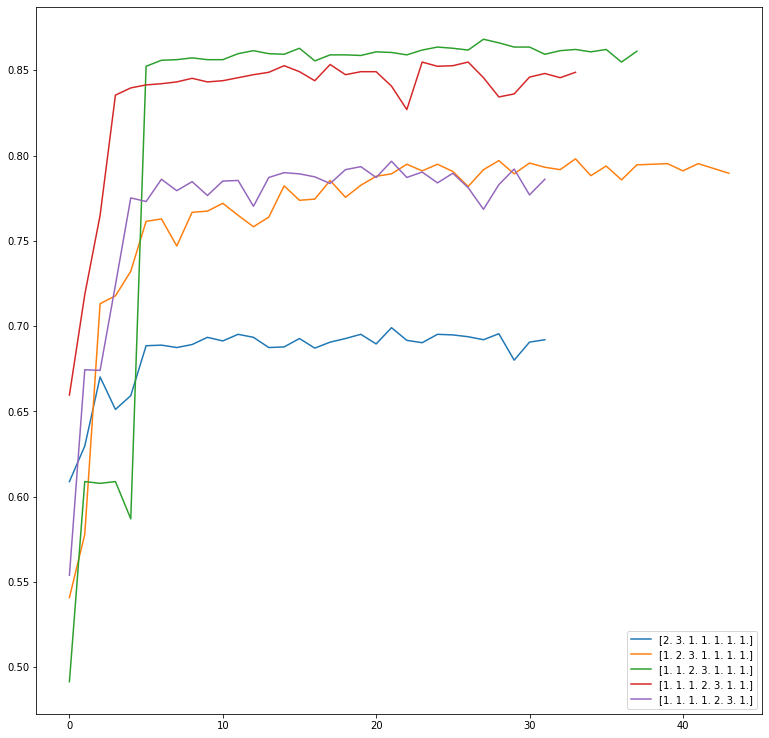

In [ ]:
#le vamos a dar diferentes ponderaciones y vamos a registrar su validation acuracy
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=10)
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

pesos=[]
for i in range(1,7):
    b=np.ones(7)
    b[i-1]=2
    b[i]=3
    pesos.append(b)

val_acc={}
for i in pesos[:-1]:
    model_multi=create_model(1,[(55,93,1)],7)
    model_multi.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

    x_train,x_test,y_train,y_test=load_dataset_mal(npy_base,telescopios=[4],list_runs=[9,10,11],test_size=0.2,normalizacion_mal=True,ponderaciones=i)

    hist=model_multi.fit(x_train,y_train,epochs=50,batch_size=128,validation_data=(x_test,y_test),callbacks=[stop])
    val_acc[str(i)]=hist.history["val_accuracy"]

a=list(val_acc.values())
plt.figure(figsize=(13,13))
for i in range(len(a)):
    plt.plot(a[i],label=list(val_acc.keys())[i])

plt.legend()

Tal y como podemos ver, parece que tenga algo que ver con que el tercero y eel cuarto (prton y helium), esten escalados o algo asi.
Vamos a probar a entrenar la red para clasificar todos menos el proton

In [ ]:
#elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']


In [ ]:
def load_dataset(base_dir,pre_name_folders="npy_",telescopios=None,list_runs=None,elementos=None,test_size=0.2,normalizacion_mal=False):#,ponderaciones=None):
    #telescopios deb ser una lista , aunque solo haya uno 1
    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    eventos_elementos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir}/{pre_name_folders}{j}"
        eventos_runs=[]
        for l,k in enumerate(list_runs):
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            eventos_runs.append(aux_events)
        eventos_elementos.append(eventos_runs)

    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]
    #prueba=ponderaciones
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir}/{pre_name_folders}{j}"
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
            if normalizacion_mal:
                maximo_aux=np.amax(data_aux)
            else:
                maximo_aux=1
            if (i==0) :
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.zeros(label_size)
                data=data_aux/maximo_aux
                del data_aux
            else:
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.concatenate((labels,np.ones(label_size)*i),axis=0)
                data=np.concatenate((data,data_aux/maximo_aux),axis=0)
                del data_aux
        #print(data.shape)
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            labels=tf.keras.utils.to_categorical(labels)
            x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
            del data,labels
            y_train_list=y_train
            y_test_list=y_test
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            #del y_train,y_test
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train)
            x_test_list.append(x_test)
        #del x_train,x_test

    if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
        print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
        return None
    else:
        print("EXITO")
        if len(telescopios)==1:
            return x_train_list[0],x_test_list[0],y_train_list,y_test_list
        else:
            return x_train_list,x_test_list,y_train_list,y_test_list



In [ ]:
#primero cargamos los datos, los primeros normales, los segundos (output) con la normalizacion guay, 
#una diferente para cada elemento
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

x_train,x_test,y_train,y_test=load_dataset(npy_base,telescopios=[4],list_runs=[9,10,11],test_size=0.2,normalizacion_mal=False,elementos=[ 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon'])

EXITO


Model: "prueba_red"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 55, 93, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 55, 93, 64)        640       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 55, 93, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 27, 46, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 27, 46, 32)        18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 23, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 23, 32)        9

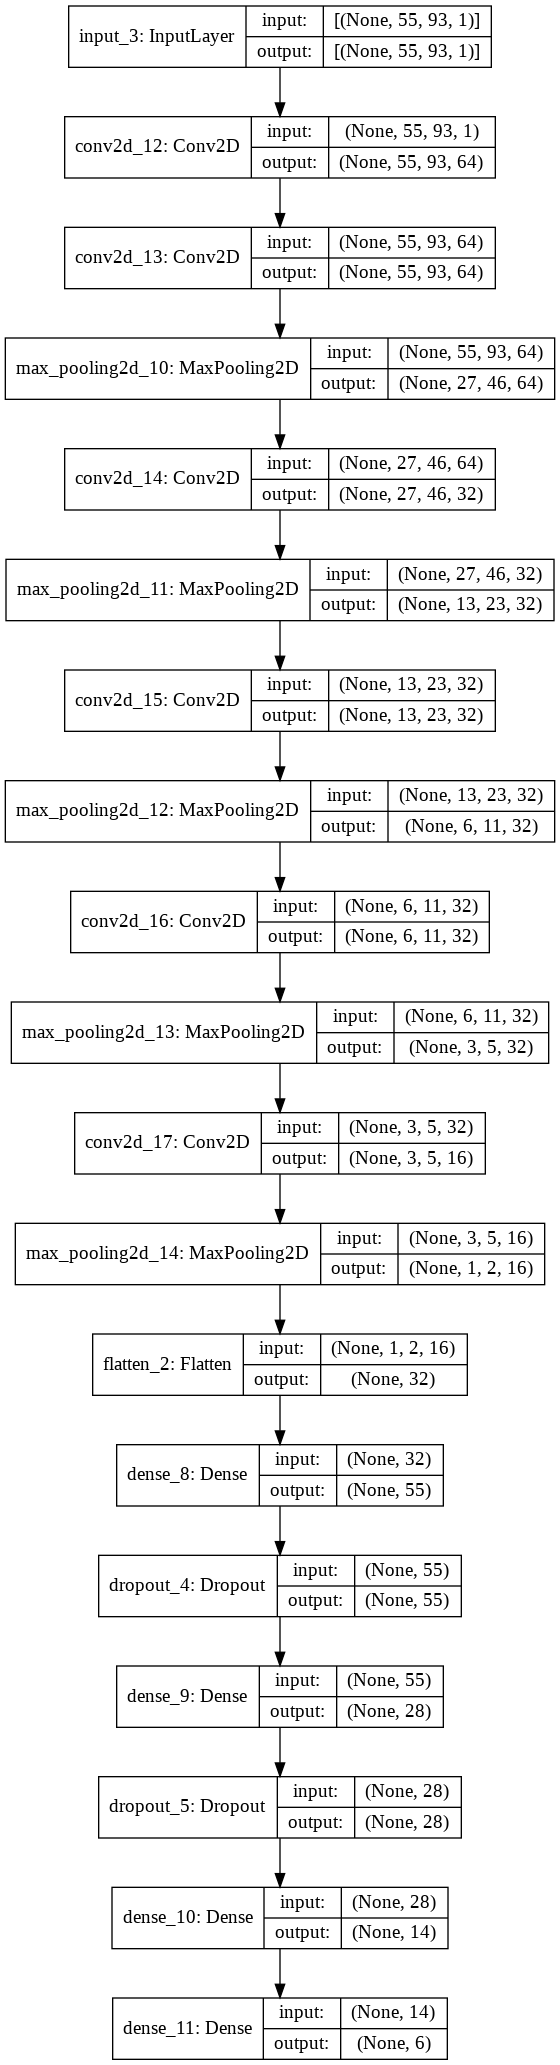

In [ ]:
model_multi=create_model(1,[(55,93,1)],6)
model_multi.summary()
tf.keras.utils.plot_model(model_multi, "prueba_1.png", show_shapes=True,expand_nested=True)

In [ ]:
model_multi.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=6)
hist=model_multi.fit(x_train,y_train,epochs=50,batch_size=128,validation_data=(x_test,y_test),callbacks=[stop])


Epoch 1/50
52/52 [==============================] - 5s 90ms/step - loss: 1.7831 - accuracy: 0.2080 - val_loss: 1.6787 - val_accuracy: 0.4054
Epoch 2/50
52/52 [==============================] - 3s 63ms/step - loss: 1.6824 - accuracy: 0.3553 - val_loss: 1.6050 - val_accuracy: 0.4237
Epoch 3/50
52/52 [==============================] - 3s 63ms/step - loss: 1.6287 - accuracy: 0.3858 - val_loss: 1.5510 - val_accuracy: 0.4005
Epoch 4/50
52/52 [==============================] - 3s 64ms/step - loss: 1.5648 - accuracy: 0.3914 - val_loss: 1.5296 - val_accuracy: 0.3950
Epoch 5/50
52/52 [==============================] - 3s 63ms/step - loss: 1.5426 - accuracy: 0.3878 - val_loss: 1.4740 - val_accuracy: 0.4328
Epoch 6/50
52/52 [==============================] - 3s 63ms/step - loss: 1.5229 - accuracy: 0.3991 - val_loss: 1.4627 - val_accuracy: 0.4249
Epoch 7/50
52/52 [==============================] - 3s 63ms/step - loss: 1.5055 - accuracy: 0.3894 - val_loss: 1.4409 - val_accuracy: 0.4408
Epoch 8/50
52

quitar los protones no ha resultado en un incremento de la precision, pero quitar ambos si, a ver, ahora tiene menos donde equivocarse, es normal que hacierte tanto si la mayoría son gammas supongo.

Tenemos que hacer que la cantidad de datos de cada uno sea mas o menos la misma, sino estamos haciendo que aprenda a clasificar mas un tipo que el resto, porque aprende mas con un tipo que con otro.


ES UN ERROR MUY GRABE, PORQUE AL TENER MUCHO MAS DE ALGO LO QUE OCURRE ES QUE OBTENEMOS UNA PRECISION MUY ALTA PUES SOLO DETECTA BIEN ESOS, NO VALE DA NA

# Mas intentos

In [ ]:
#MODIFICACION PARA QUE HAYA MAS O MENOS LA MISMA CANTIDAD DE DATOS DE CADA UNO.
def load_dataset(base_dir,pre_name_folders="npy_",telescopios=None,list_runs=None,elementos=None,test_size=0.2,normalizacion_mal=False,same_quant=True):#,ponderaciones=None):
    #telescopios deb ser una lista , aunque solo haya uno 1
    if elementos==None:
        elementos=['gamma', 'electron', 'proton', 'helium', 'iron', 'nitrogen', 'silicon']
    #para cada elemento y para cada RUN tenemos que indicar los eventos validos
    eventos_elementos=[]
    numero_eventos=[]
    for i,j in enumerate(elementos):
        dir_aux=f"{base_dir}/{pre_name_folders}{j}"
        eventos_runs=[]
        for l,k in enumerate(list_runs):
            aux_events=get_common_events(dir_aux,tels=telescopios,run=k)
            eventos_runs.append(aux_events)
            numero_eventos.append(aux_events.shape[1])
        eventos_elementos.append(eventos_runs)

    #ahora tenemos los eventos que sí nos valen porque estan en todos los telescopios a considerar 
    x_train_list=[]
    x_test_list=[]
    #prueba=ponderaciones
    for l,k in enumerate(telescopios):
        for i,j in enumerate(elementos):
            dir_aux=f"{base_dir}/{pre_name_folders}{j}"
            #TENEMOS QUE TENER UNA LISTA DE LOS INDICES QUE SÍ COMPARTEN ID, EL RESTO NO NOS INTERESA
            #lo que hacemos es pasarle una lista de los indices PARA:
            #PARA el elemento que toca y el telescopio qeu toca, para todas las runs que queremos 
            if same_quant:
                aux_quant=int(np.median(numero_eventos))
                data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:aux_quant] for m in eventos_elementos[i]],only_names=False)
            else:
                data_aux=load_data(dir_aux,tels=k,runs=list_runs,indices_runs=[m[l,:] for m in eventos_elementos[i]],only_names=False)
            print(data_aux.shape)
            if normalizacion_mal:
                maximo_aux=np.amax(data_aux)
            else:
                maximo_aux=1
            if (i==0) :
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.zeros(label_size)
                data=data_aux/maximo_aux
                del data_aux
            else:
                if l==0:
                    label_size=data_aux.shape[0]
                    labels=np.concatenate((labels,np.ones(label_size)*i),axis=0)
                data=np.concatenate((data,data_aux/maximo_aux),axis=0)
                del data_aux
        #print(data.shape)
        #ahora le aumentamos el canal y las labels las volvemos categorical
        data=data[...,np.newaxis]
        if l==0:
            labels=tf.keras.utils.to_categorical(labels)
            x_train,x_test,y_train,y_test =train_test_split(data,labels,test_size=test_size,random_state=42)
            del data,labels
            y_train_list=y_train
            y_test_list=y_test
            x_train_list.append(x_train)
            x_test_list.append(x_test)
            #del y_train,y_test
        else:
            x_train,x_test =train_test_split(data,test_size=test_size,random_state=42)
            x_train_list.append(x_train)
            x_test_list.append(x_test)
        #del x_train,x_test

    if (x_train.shape[0]!=y_train.shape[0]) or (x_test.shape[0]!=y_test.shape[0]):
        print("Ha habido algún problema con las dimensiones y eso...te jodes lo siento")
        return None
    else:
        print("EXITO")
        if len(telescopios)==1:
            return x_train_list[0],x_test_list[0],y_train_list,y_test_list
        else:
            return x_train_list,x_test_list,y_train_list,y_test_list



In [ ]:
#primero cargamos los datos, los primeros normales, los segundos (output) con la normalizacion guay, 
#una diferente para cada elemento
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21/npy_data"

x_train,x_test,y_train,y_test=load_dataset(npy_base,telescopios=[6,11,4,5],list_runs=[8,9],test_size=0.2,normalizacion_mal=False,same_quant=True)

(266, 55, 93)
(209, 55, 93)
(266, 55, 93)
(266, 55, 93)
(247, 55, 93)
(239, 55, 93)
(263, 55, 93)
(266, 55, 93)
(209, 55, 93)
(266, 55, 93)
(266, 55, 93)
(247, 55, 93)
(239, 55, 93)
(263, 55, 93)
(266, 55, 93)
(209, 55, 93)
(266, 55, 93)
(266, 55, 93)
(247, 55, 93)
(239, 55, 93)
(263, 55, 93)
(266, 55, 93)
(209, 55, 93)
(266, 55, 93)
(266, 55, 93)
(247, 55, 93)
(239, 55, 93)
(263, 55, 93)
EXITO


In [ ]:
model_multi=create_model(4,[(55,93,1)],7)
model_multi.summary()
tf.keras.utils.plot_model(model_multi, "prueba_1.png", show_shapes=True,expand_nested=True)

NameError: ignored

In [ ]:
model_multi.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=7)
hist=model_multi.fit(x_train,y_train,epochs=50,batch_size=64,validation_data=(x_test,y_test),callbacks=[stop])


NameError: ignored

In [ ]:
npy_base="/content/drive/MyDrive/prediccion_datos_muchos_telescopios/datos_muchos_tels_seleccion_6_03_21"

#creamos el model de zero
#tenemos 4 inputs
telesc=4
input1=tf.keras.Input(shape=(55,93,1))
input2=tf.keras.Input(shape=(55,93,1))
input3=tf.keras.Input(shape=(55,93,1))
input4=tf.keras.Input(shape=(55,93,1))

autoencoder=tf.keras.models.load_model(f"{npy_base}/autoencoder_bien.h5")
autoencoder.trainable=False
#entran los 4 inputs y nos dan 4 outputs diferentes

output1=autoencoder(input1)
output2=autoencoder(input2)
output3=autoencoder(input3)
output4=autoencoder(input4)

#ahora los outputs los procesamos tal que todos se procesan por el mismo submodelo
aux_input=tf.keras.Input(shape=(55,93,1))
x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(aux_input)
#x=tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu")(x)
#x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu")(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Flatten()(x)
submodel_conv=tf.keras.Model(inputs=aux_input,outputs=x)


final_output1=submodel_conv(output1)
final_output2=submodel_conv(output2)
final_output3=submodel_conv(output3)
final_output4=submodel_conv(output4)

end_layer=tf.keras.layers.concatenate([final_output1,final_output2,final_output3,final_output4])
end_layer=tf.keras.layers.Dense(70,activation="relu")(end_layer)
end_layer=tf.keras.layers.Dense(7,activation="softmax")(end_layer)
model=tf.keras.Model(inputs=[input1,input2,input3,input4],outputs=end_layer,name="prueba_red")

Model: "prueba_red"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 55, 93, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 55, 93, 1)]  0                                            
_________________________________________________________________________________________

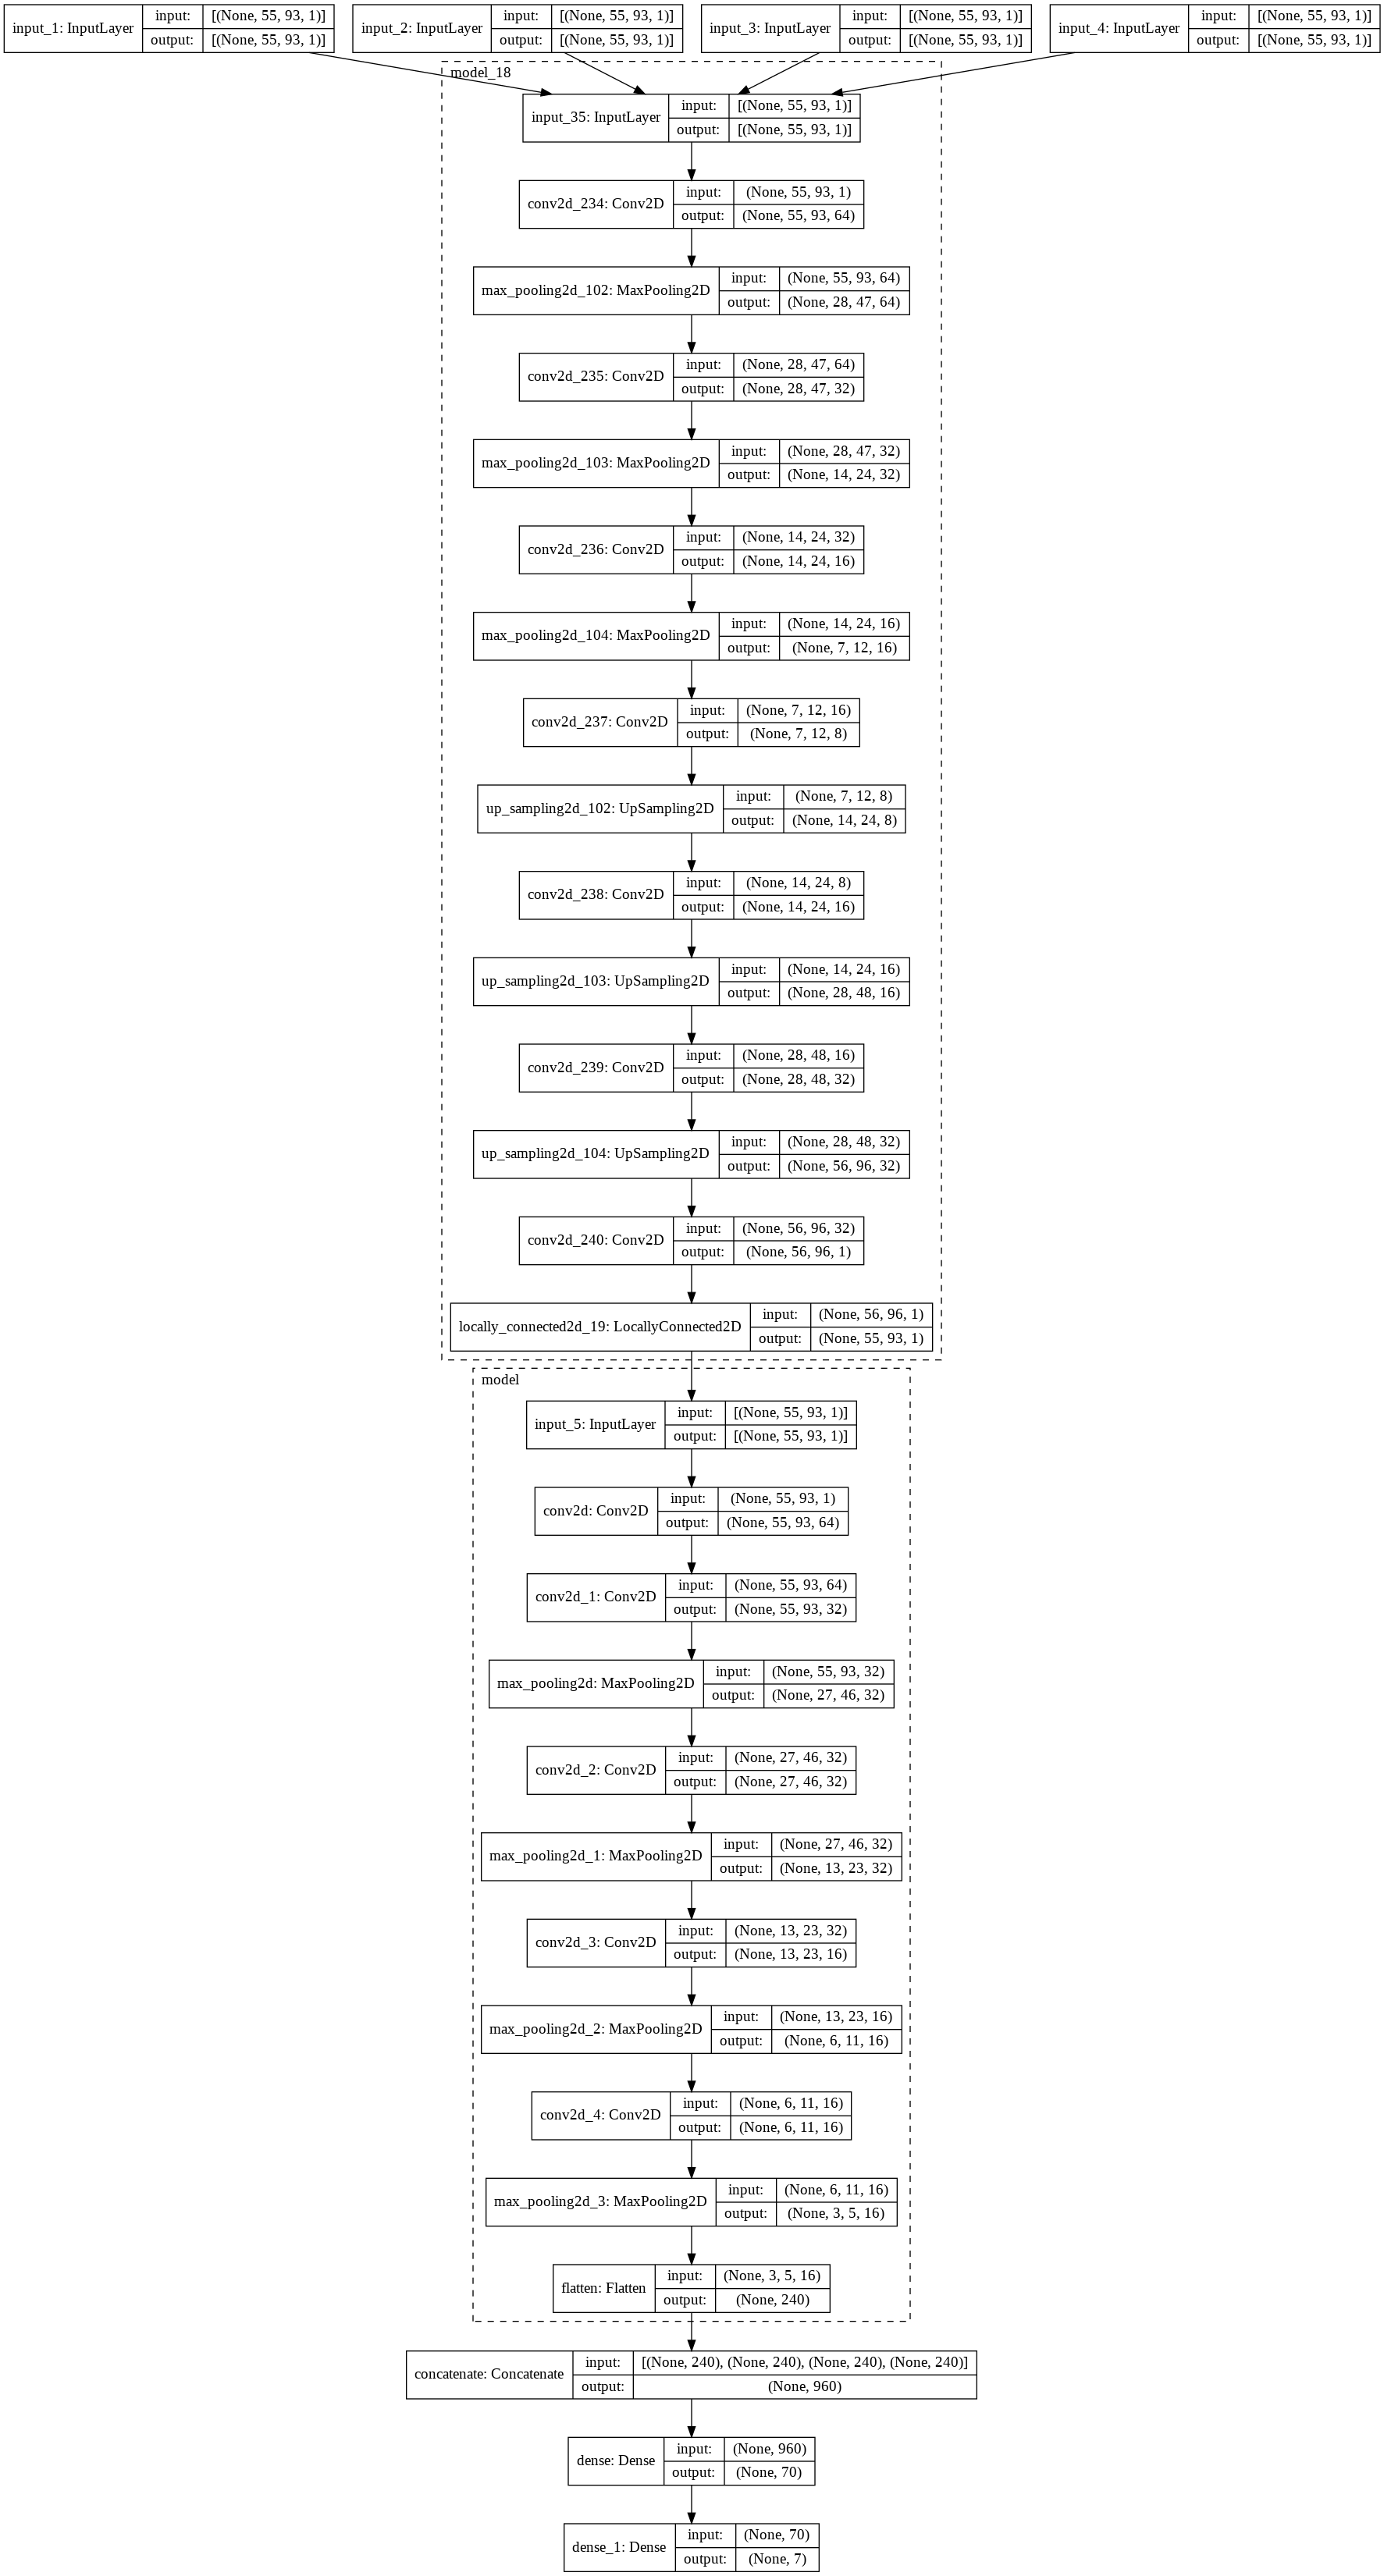

In [ ]:
#model=create_model(4,[(55,93,1)],7)
model.summary()
tf.keras.utils.plot_model(model, "prueba_1.png", show_shapes=True,expand_nested=True)

In [ ]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
stop=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=7)
hist2=model.fit(x_train,y_train,epochs=50,batch_size=64,validation_data=(x_test,y_test),callbacks=[stop])


Epoch 1/50
22/22 [==============================] - ETA: 0s - loss: 1.9382 - accuracy: 0.1795